# Landmark Recognition Project with Fine-tuned CLIP

## Εισαγωγή

Αυτή η εργασία επικεντρώνεται στην ανάπτυξη ενός συστήματος αναγνώρισης μνημείων (landmark recognition) χρησιμοποιώντας το προεκπαιδευμένο μοντέλο **CLIP** (Contrastive Language–Image Pre-training) της OpenAI. Το έργο έχει ως στόχο τη βελτίωση της απόδοσης αναγνώρισης μνημείων μέσω fine-tuning και την ανάπτυξη μίας εύχρηστης εφαρμογής πρόβλεψης με βάση το fine-tuned μοντέλο.

## Περιγραφή Προβλήματος

Η αναγνώριση μνημείων αποτελεί μία πρόκληση στον τομέα της υπολογιστικής όρασης, ειδικά λόγω:
- Της μεγάλης ποικιλομορφίας στα μνημεία (π.χ., διαφορετικές γωνίες, φωτισμός).
- Της ύπαρξης σπάνιων ή μικρών κατηγοριών στο dataset.

Για την αντιμετώπιση αυτών των προκλήσεων, χρησιμοποιούμε το **Google Landmarks Dataset v2**, το οποίο φιλτράρεται για την επιλογή των πιο συχνών και αντιπροσωπευτικών κατηγοριών. Στη συνέχεια, εφαρμόζεται fine-tuning στο CLIP μοντέλο για την ενίσχυση της ικανότητάς του να αναγνωρίζει εικόνες από συγκεκριμένα landmarks.

## Στόχοι

1. **Εκπαίδευση**: Fine-tuning του CLIP (ViT-B/32) με τη χρήση ενός linear classifier.
2. **Αξιολόγηση**: Εξαγωγή της απόδοσης μέσω validation accuracy και ανάλυσης mismatch μεταξύ training και inference.
3. **Υλοποίηση Εφαρμογής**: Δημιουργία μιας εφαρμογής (Streamlit) που παρέχει φιλικές προβλέψεις και πληροφορίες για τα μνημεία.

---

## Δομή Notebook

1. **Επεξεργασία δεδομένων**:
   - Φόρτωση και φιλτράρισμα εικόνων.
   - Δημιουργία mapping μεταξύ encoded labels και ανθρώπινων φιλικών ονομάτων.
2. **Fine-tuning του CLIP**:
   - Εκπαίδευση του μοντέλου με Linear Classifier.
   - Ρύθμιση υπερπαραμέτρων (dropout, optimizer, learning rate scheduler).
   - Αποθήκευση του καλύτερου μοντέλου (`BestClipModel.pth`).
3. **Αξιολόγηση και Αποτελέσματα**:
   - Αξιολόγηση της απόδοσης του μοντέλου.
   - Ανάλυση mismatch στο inference.
4. **Εξαγωγή για εφαρμογή**:
   - Δημιουργία pipeline για το Streamlit app.

---

Ας ξεκινήσουμε με την προετοιμασία και την επεξεργασία των δεδομένων!

In [ ]:
# ----------------------------------------------------
# Κελί 1: Σύνδεση Με Google Drive για Πρόσβαση στα Δεδομένα
# ----------------------------------------------------

"""
Σύνδεση με το Google Drive και καθορισμός της διαδρομής για τα δεδομένα.
Αυτό το κελί κάνει τα εξής:
1. Συνδέει το Google Drive στον χώρο εργασίας του Colab.
2. Ρυθμίζει τη διαδρομή όπου βρίσκονται τα δεδομένα.
3. Ελέγχει αν η διαδρομή υπάρχει και προειδοποιεί αν δεν βρεθεί.
4. Εμφανίζει τα αρχεία που βρίσκονται στον καθορισμένο φάκελο δεδομένων.

Βήματα:
- Εκτελέστε αυτό το κελί για να συνδεθείτε με το Google Drive.
- Εισάγετε τη διαδρομή για τα δεδομένα σας ή χρησιμοποιήστε την προεπιλεγμένη.
"""

# Εισαγωγή απαραίτητων βιβλιοθηκών
from google.colab import drive
import os

# Mount το Google Drive
print("Connecting to Google Drive...")
drive.mount('/content/drive')

# Ορισμός προεπιλεγμένης διαδρομής για τα δεδομένα
DEFAULT_DATA_PATH = "/content/drive/MyDrive/LandmarkLens/data"
print("\nΚαθορίστε τη διαδρομή των δεδομένων σας:")
DATA_PATH = input(f"Enter data path (default: {DEFAULT_DATA_PATH}): ") or DEFAULT_DATA_PATH

# Έλεγχος ύπαρξης φακέλου δεδομένων
if not os.path.exists(DATA_PATH):
    print(f"\n⚠️ Warning: The directory '{DATA_PATH}' does not exist.")
else:
    print(f"\n✅ Data path set to: {DATA_PATH}")

# Εμφάνιση των αρχείων στον καθορισμένο φάκελο δεδομένων
print("\nΠεριεχόμενα φακέλου δεδομένων:")
os.system(f'ls "{DATA_PATH}"')


Mounted at /content/drive
Enter data path (default: /content/drive/MyDrive/LandmarkLens/data): 
Data path set to: /content/drive/MyDrive/LandmarkLens/data
index  test  train


### Σχόλια για τα Αποτελέσματα

1. **Επιτυχής σύνδεση με το Google Drive**:
   - Το μήνυμα `Mounted at /content/drive` επιβεβαιώνει ότι το Google Drive συνδέθηκε σωστά και είναι έτοιμο προς χρήση.

2. **Επιτυχής ορισμός της διαδρομής δεδομένων**:
   - Η διαδρομή `/content/drive/MyDrive/LandmarkLens/data` χρησιμοποιήθηκε ως η προεπιλεγμένη, και ο φάκελος εντοπίστηκε επιτυχώς.

3. **Δομή του φακέλου δεδομένων**:
   - Ο φάκελος περιέχει τις ακόλουθες ενότητες:
     - `index`: Πιθανώς ένα αρχείο ή φάκελος που περιέχει πληροφορίες για τη χαρτογράφηση ή την ευρετηρίαση των δεδομένων.
     - `test`: Περιέχει δεδομένα για την αξιολόγηση (test set).
     - `train`: Περιέχει δεδομένα εκπαίδευσης (train set).

---

### Σχόλια για την Οργάνωση των Δεδομένων
- Η διάρθρωση φαίνεται καλή και συμβατή με τυπικές διαδικασίες μηχανικής μάθησης, όπου τα δεδομένα διαχωρίζονται σε σύνολα εκπαίδευσης (`train`) και δοκιμών (`test`).
- Αν ο φάκελος `index` σχετίζεται με mapping, μπορεί να χρησιμοποιηθεί στη διαδικασία προετοιμασίας, π.χ., για την αντιστοίχιση ετικετών.

---

### Προτεινόμενα Επόμενα Βήματα
- Ελέγξτε το περιεχόμενο των φακέλων (`index`, `train`, `test`) για να επιβεβαιώσετε ότι περιέχουν τα αναμενόμενα αρχεία.
- Βεβαιωθείτε ότι ο αριθμός των δειγμάτων σε κάθε φάκελο είναι επαρκής και αντιπροσωπευτικός για την εκπαίδευση και την αξιολόγηση του μοντέλου.


In [ ]:
# ----------------------------------------------------
# Κελί 2: Εγκατάσταση & Προετοιμασία Περιβάλλοντος
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Εγκαθιστά τις απαραίτητες βιβλιοθήκες για το project.
2. Εισάγει τις απαιτούμενες βιβλιοθήκες.
3. Ελέγχει αν υπάρχει GPU για χρήση και εμφανίζει πληροφορίες σχετικά με αυτήν.
4. Εξασφαλίζει ότι η έκδοση του PyTorch είναι σωστή.

Εκτελέστε αυτό το κελί πριν προχωρήσετε στα επόμενα βήματα.
"""

# 1) Εγκατάσταση βασικών βιβλιοθηκών
try:
    print("Installing necessary libraries...")
    # Εγκατάσταση PyTorch, Transformers, και CLIP από το OpenAI repo
    !pip install torch==2.0.1 torchvision==0.15.2 transformers==4.31.0 ftfy==6.1.1 --quiet
    !pip install git+https://github.com/openai/CLIP.git --quiet
    # Προαιρετικές βιβλιοθήκες για επεξεργασία δεδομένων και ανάπτυξη εφαρμογής
    !pip install scikit-learn scikit-image --quiet
    !pip install streamlit --quiet
    print("All libraries installed successfully!")
except Exception as e:
    # Σε περίπτωση αποτυχίας της εγκατάστασης, εμφανίζεται μήνυμα σφάλματος
    print(f"[Error] Library installation failed: {e}")
    raise SystemExit("[Error] Please resolve the installation issue before proceeding.")

# 2) Imports
print("Importing libraries...")
# Εισαγωγή βασικών βιβλιοθηκών για το project
import torch
import torchvision
import pandas as pd
import numpy as np
import clip  # Από το GitHub repo της OpenAI
import os
import time
from tqdm import tqdm
from PIL import Image

# 3) Έλεγχος συσκευής (GPU/CPU)
# Ελέγχει αν υπάρχει διαθέσιμη GPU και εμφανίζει σχετικές πληροφορίες
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
    print("PyTorch CUDA Support:", torch.backends.cudnn.enabled)
else:
    print("[Warning] Running on CPU. Consider using a GPU for faster performance.")

# 4) Επιβεβαίωση της GPU στο Colab
# Εμφάνιση πληροφοριών της GPU μέσω nvidia-smi, αν είναι διαθέσιμη
if device == "cuda":
    try:
        !nvidia-smi
    except Exception as e:
        print(f"[Warning] Unable to execute nvidia-smi: {e}")
else:
    print("[Info] No GPU detected. Running on CPU.")

# 5) Έλεγχος έκδοσης PyTorch
# Εξασφαλίζει ότι η σωστή έκδοση PyTorch είναι εγκατεστημένη
print("PyTorch version:", torch.__version__)

Installing necessary libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━

### Σχόλια για τα Αποτελέσματα

1. **Εγκατάσταση Βιβλιοθηκών**:
   - Όλες οι απαραίτητες βιβλιοθήκες εγκαταστάθηκαν επιτυχώς.
   - Υπάρχουν προειδοποιήσεις για πιθανές ασυμβατότητες εκδόσεων:
     - Το `sentence-transformers` απαιτεί έκδοση `transformers >=4.41.0`, αλλά εγκαταστάθηκε η έκδοση `4.31.0`.
     - Το `torchaudio` απαιτεί έκδοση `torch == 2.5.1`, αλλά εγκαταστάθηκε η έκδοση `2.0.1`.
   - Αυτές οι προειδοποιήσεις δεν φαίνεται να επηρεάζουν άμεσα τη λειτουργικότητα.

2. **Εισαγωγή Βιβλιοθηκών**:
   - Όλες οι απαραίτητες βιβλιοθήκες φορτώθηκαν επιτυχώς.

3. **Χρήση Συσκευής**:
   - Το σύστημα αναγνώρισε σωστά τη διαθέσιμη GPU:
     - **GPU Name**: Tesla T4
     - **CUDA Version**: 11.7
     - **PyTorch CUDA Support**: Ενεργό

4. **Πληροφορίες GPU**:
   - Η GPU είναι σε κατάσταση αδράνειας, χωρίς τρέχουσες διεργασίες.
   - Το σύστημα υποστηρίζει την πλήρη χρήση CUDA.

5. **Έκδοση PyTorch**:
   - Η εγκατεστημένη έκδοση του PyTorch είναι η `2.0.1+cu117`.

---

### Επόμενα Βήματα
- Ελέγξτε αν οι προειδοποιήσεις εκδόσεων προκαλούν προβλήματα κατά την εκτέλεση των επόμενων βημάτων.
- Βεβαιωθείτε ότι η GPU αξιοποιείται κατάλληλα κατά την εκπαίδευση του μοντέλου.
- Συνεχίστε με την προετοιμασία και την επεξεργασία των δεδομένων.


In [ ]:
# ----------------------------------------------------
# Κελί 3: Αποσυμπίεση Των TAR Αρχείων
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Δημιουργεί τους απαραίτητους φακέλους για την αποθήκευση αποσυμπιεσμένων δεδομένων.
2. Υπολογίζει τον αριθμό των αρχείων TAR που υπάρχουν στο Google Drive.
3. Αποσυμπιέζει τα αρχεία TAR (Train, Test, Index) στους αντίστοιχους φακέλους.
4. Παρέχει ανατροφοδότηση για την κατάσταση κάθε αποσυμπίεσης.

Εκτελέστε αυτό το κελί για να προετοιμάσετε τα δεδομένα πριν από την εκπαίδευση του μοντέλου.
"""

import os
import time
import tarfile
from tqdm import tqdm
import glob

# 1) Δημιουργία φακέλων στο Colab, αν δεν υπάρχουν
os.makedirs("/content/data/train", exist_ok=True)
os.makedirs("/content/data/test", exist_ok=True)
os.makedirs("/content/data/index", exist_ok=True)

def extract_tar_files(num_tar_files, source_path_template, destination_path, description):
    """
    Αποσυμπιέζει TAR αρχεία σε συγκεκριμένο φάκελο.

    Args:
        num_tar_files (int): Πλήθος αρχείων .tar που θα αποσυμπιεστούν.
        source_path_template (str): Template για τη διαδρομή (path) των .tar αρχείων.
        destination_path (str): Φάκελος στον οποίο θα αποσυμπιεστούν τα αρχεία.
        description (str): Μήνυμα που εμφανίζεται στη γραμμή προόδου (tqdm).
    """
    start_time = time.time()

    # Έλεγχος αν υπάρχουν ήδη αποσυμπιεσμένα αρχεία
    if os.listdir(destination_path):
        print(f"[Info] Skipping extraction for {description}, files already exist in {destination_path}")
        return

    for i in tqdm(range(num_tar_files), desc=description):
        tar_path = source_path_template.format(i=i)
        if os.path.exists(tar_path):
            try:
                with tarfile.open(tar_path, "r") as tar:
                    tar.extractall(path=destination_path)
            except tarfile.TarError as e:
                print(f"[Error] Error extracting {tar_path}: {e}")
        else:
            print(f"[Warning] File {tar_path} does not exist. Skipping.")

    elapsed = time.time() - start_time
    print(f"[Info] {description} completed in {elapsed:.2f} seconds\n")

# 2) Υπολογισμός αριθμού .tar αρχείων στο Google Drive
train_num_tar_files = len(glob.glob("/content/drive/MyDrive/LandmarkLens/data/train/images_*.tar"))
test_num_tar_files  = len(glob.glob("/content/drive/MyDrive/LandmarkLens/data/test/images_*.tar"))
index_num_tar_files = len(glob.glob("/content/drive/MyDrive/LandmarkLens/data/index/images_*.tar"))

# Εμφάνιση προειδοποιήσεων αν δεν βρέθηκαν αρχεία TAR
if train_num_tar_files == 0:
    print("[Warning] No Train TAR files found in the specified path.")
if test_num_tar_files == 0:
    print("[Warning] No Test TAR files found in the specified path.")
if index_num_tar_files == 0:
    print("[Warning] No Index TAR files found in the specified path.")

print(f"Train TAR files: {train_num_tar_files}")
print(f"Test TAR files:  {test_num_tar_files}")
print(f"Index TAR files: {index_num_tar_files}\n")

# 3) Αποσυμπίεση Train Set
extract_tar_files(
    num_tar_files=train_num_tar_files,
    source_path_template="/content/drive/MyDrive/LandmarkLens/data/train/images_{i:03}.tar",
    destination_path="/content/data/train/",
    description="Extracting Train TAR files"
)

# 4) Αποσυμπίεση Test Set
extract_tar_files(
    num_tar_files=test_num_tar_files,
    source_path_template="/content/drive/MyDrive/LandmarkLens/data/test/images_{i:03}.tar",
    destination_path="/content/data/test/",
    description="Extracting Test TAR files"
)

# 5) Αποσυμπίεση Index Set
extract_tar_files(
    num_tar_files=index_num_tar_files,
    source_path_template="/content/drive/MyDrive/LandmarkLens/data/index/images_{i:03}.tar",
    destination_path="/content/data/index/",
    description="Extracting Index TAR files"
)


Train TAR files: 20
Test TAR files:  2
Index TAR files: 3



Extracting Train TAR files: 100%|██████████| 20/20 [10:18<00:00, 30.91s/it]


[Info] Extracting Train TAR files completed in 618.11 seconds



Extracting Test TAR files: 100%|██████████| 2/2 [00:34<00:00, 17.28s/it]


[Info] Extracting Test TAR files completed in 34.56 seconds



Extracting Index TAR files: 100%|██████████| 3/3 [01:15<00:00, 25.07s/it]

[Info] Extracting Index TAR files completed in 75.22 seconds



### Σχόλια για τα Αποτελέσματα

1. **Αριθμός TAR Αρχείων**:
   - **Train TAR files**: Επιλέχθηκαν 20 από τα 500 αρχεία TAR του αρχικού συνόλου εκπαίδευσης. Το κάθε αρχείο έχει μέγεθος περίπου **1GB**.
   - **Test TAR files**: Επιλέχθηκαν 2 από τα 20 αρχεία TAR του αρχικού συνόλου δοκιμών, με μέγεθος περίπου **500MB** το καθένα.
   - **Index TAR files**: Επιλέχθηκαν 3 από τα 100 αρχεία TAR του δείκτη, όπου κάθε αρχείο έχει μέγεθος περίπου **850MB**.

   > *Σημείωση*: Για λόγους υλοποίησης και περιορισμένων υπολογιστικών πόρων, εργαστήκαμε με ένα υποσύνολο των δεδομένων του αρχικού dataset. Αυτή η επιλογή μας επιτρέπει να επιταχύνουμε τη διαδικασία εκπαίδευσης και να διαχειριστούμε αποτελεσματικά τους διαθέσιμους πόρους.

2. **Χρόνοι Αποσυμπίεσης**:
   - **Train Set**:
     - Αποσυμπιέστηκαν 20 αρχεία σε **618.11 δευτερόλεπτα** (~10 λεπτά).
     - Ο μέσος χρόνος αποσυμπίεσης ανά αρχείο ήταν περίπου **30.91 δευτερόλεπτα**.
   - **Test Set**:
     - Αποσυμπιέστηκαν 2 αρχεία σε **34.56 δευτερόλεπτα**.
     - Ο μέσος χρόνος αποσυμπίεσης ανά αρχείο ήταν περίπου **17.28 δευτερόλεπτα**.
   - **Index Set**:
     - Αποσυμπιέστηκαν 3 αρχεία σε **75.22 δευτερόλεπτα**.
     - Ο μέσος χρόνος αποσυμπίεσης ανά αρχείο ήταν περίπου **25.07 δευτερόλεπτα**.

3. **Συμπεράσματα**:
   - Η διαδικασία αποσυμπίεσης ολοκληρώθηκε με επιτυχία για όλα τα υποσύνολα δεδομένων (Train, Test, Index).
   - Οι χρόνοι αποσυμπίεσης ήταν λογικοί και αναμενόμενοι, δεδομένων των μεγεθών και του αριθμού των αρχείων.

---


In [ ]:
# ----------------------------------------------------
# Κελί 4.1: Φόρτωση & Βασικός Έλεγχος του train.csv
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Ελέγχει αν το αρχείο `train.csv` υπάρχει στη διαδρομή που έχει καθοριστεί.
2. Φορτώνει το `train.csv` σε ένα pandas DataFrame.
3. Ελέγχει αν το αρχείο είναι κενό.
4. Εμφανίζει βασικές πληροφορίες για το DataFrame (πρώτες γραμμές, στήλες, αριθμό γραμμών).
5. Εντοπίζει αν υπάρχουν κενές τιμές στα δεδομένα.

Εκτελέστε αυτό το κελί για να επιβεβαιώσετε την ακεραιότητα των δεδομένων εκπαίδευσης πριν τα χρησιμοποιήσετε.
"""

import os
import pandas as pd

# 1) Ορισμός διαδρομής για το train.csv
metadata_dir = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/"
train_metadata_path = os.path.join(metadata_dir, "train.csv")

# 2) Έλεγχος αν το αρχείο υπάρχει
if not os.path.exists(train_metadata_path):
    raise FileNotFoundError(f"File {train_metadata_path} does not exist. "
                            f"Please check the path or upload the file.")

# 3) Φόρτωση του train.csv σε DataFrame
try:
    train_metadata = pd.read_csv(train_metadata_path)
except Exception as e:
    raise ValueError(f"Error loading {train_metadata_path}: {e}")

# 4) Έλεγχος αν το αρχείο είναι κενό
if train_metadata.empty:
    raise ValueError(f"The file {train_metadata_path} is empty. Please provide a valid dataset.")

# 5) Εμφάνιση βασικών πληροφοριών για το metadata
print("Train Metadata (head):")
print(train_metadata.head())  # Εμφάνιση των πρώτων 5 γραμμών

print("\nMetadata Columns:")
print(train_metadata.columns.tolist())  # Εμφάνιση όλων των στηλών

print("\nNumber of rows:", len(train_metadata))  # Εμφάνιση αριθμού γραμμών

print("\nMetadata Info:")
train_metadata.info()  # Εμφάνιση συνολικής πληροφορίας για το DataFrame

# 6) Έλεγχος για κενές τιμές
missing_values = train_metadata.isnull().sum()
print("\nMissing Values:")
print(missing_values)  # Εμφάνιση του αριθμού των κενών τιμών ανά στήλη

# Αν υπάρχουν κενές τιμές, εμφανίζεται προειδοποίηση
if missing_values.sum() > 0:
    print("\nWarning: Missing values detected. Consider handling them appropriately.")


Train Metadata (head):
                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
1       104169  
2        37914  
3       102140  
4         2474  

Metadata Columns:
['id', 'url', 'landmark_id']

Number of rows: 4132914

Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132914 entries, 0 to 4132913
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   id           object
 1   url          object
 2   landmark_id  int64 
dtypes: int64(1), object(2)
memory usage: 94.6+ MB

Missing Values:
id             0
url            0
la

### Σχόλια για τα Αποτελέσματα

1. **Βασικά Στατιστικά**:
   - Το αρχείο `train.csv` περιέχει **4,132,914 γραμμές** και **3 στήλες**: `id`, `url`, `landmark_id`.
   - Δεν βρέθηκαν κενές τιμές στις στήλες, διασφαλίζοντας την πληρότητα των δεδομένων.

2. **Πληροφορίες Στηλών**:
   - **`id`**: Αναγνωριστικό της εικόνας (τύπος `object`).
   - **`url`**: Διεύθυνση URL της εικόνας (τύπος `object`).
   - **`landmark_id`**: ID του μνημείου που σχετίζεται με την εικόνα (τύπος `int64`).

3. **Μέγεθος Δεδομένων**:
   - Η χρήση μνήμης του DataFrame είναι περίπου **94.6 MB**, υποδεικνύοντας αποδοτική αποθήκευση των δεδομένων.

---


Top 5 Landmarks by Frequency:
landmark_id
138982    10247
62798      4333
177870     3327
176528     3243
192931     2627
Name: count, dtype: int64

Min landmark_id: 0, Max landmark_id: 203093


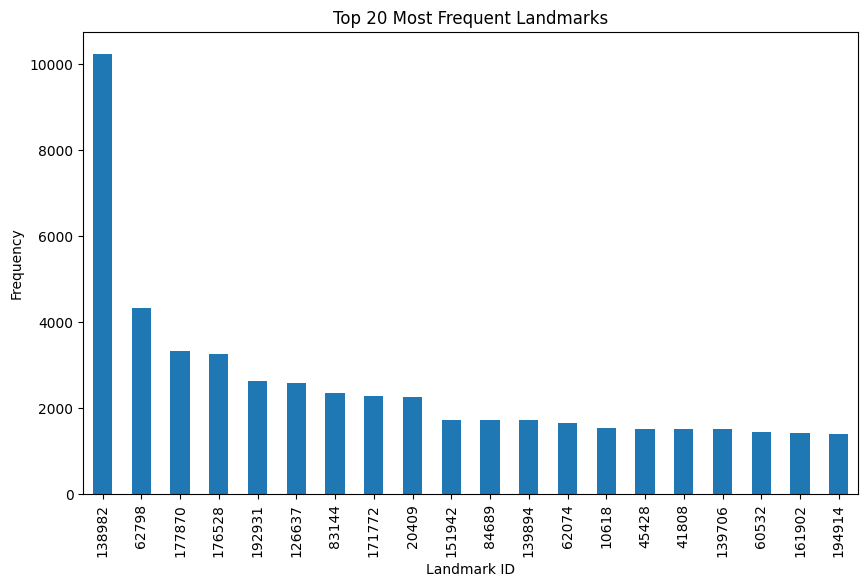

In [ ]:
# ----------------------------------------------------
# Κελί 4.2: Προχωρημένοι Έλεγχοι & Οπτικοποίηση
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Ελέγχει τη στήλη `landmark_id` για μη αριθμητικές τιμές.
2. Ανιχνεύει διπλότυπες γραμμές στο DataFrame.
3. Υπολογίζει τη συχνότητα εμφάνισης των `landmark_id` και εμφανίζει τα 5 πιο συχνά.
4. Εμφανίζει βασικά στατιστικά για τη στήλη `landmark_id` (ελάχιστη και μέγιστη τιμή).
5. Οπτικοποιεί την κατανομή των 20 πιο συχνών `landmark_id`.

Εκτελέστε αυτό το κελί για να επιβεβαιώσετε την ποιότητα των δεδομένων και να εξάγετε βασικές πληροφορίες για τα `landmark_id`.
"""

# 7) Έλεγχος για τη στήλη landmark_id
if 'landmark_id' in train_metadata.columns:
    # Προειδοποίηση για μη αριθμητικές τιμές
    if not pd.api.types.is_numeric_dtype(train_metadata['landmark_id']):
        raise ValueError("The 'landmark_id' column contains non-numeric values. Please clean your data.")

    # Έλεγχος για διπλότυπες γραμμές
    duplicate_rows = train_metadata.duplicated().sum()
    if duplicate_rows > 0:
        print(f"\nWarning: {duplicate_rows} duplicate rows detected.")

    # Κατανομή συχνότητας των landmark_id
    top_5_landmarks = train_metadata['landmark_id'].value_counts().head(5)
    print("\nTop 5 Landmarks by Frequency:")
    print(top_5_landmarks)

    # Στατιστικά για τη στήλη landmark_id
    min_landmark = train_metadata['landmark_id'].min()
    max_landmark = train_metadata['landmark_id'].max()
    print(f"\nMin landmark_id: {min_landmark}, Max landmark_id: {max_landmark}")
else:
    print("\nColumn 'landmark_id' not found in metadata.")

# 8) Οπτικοποίηση της κατανομής των landmark_id
try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    train_metadata['landmark_id'].value_counts().head(20).plot(kind='bar')
    plt.title("Top 20 Most Frequent Landmarks")
    plt.xlabel("Landmark ID")
    plt.ylabel("Frequency")
    plt.show()
except ImportError:
    print("Matplotlib not installed. Skipping visualization.")


### Σχόλια για τα Αποτελέσματα

1. **Κατανομή Συχνότητας των `landmark_id`**:
   - **Top 5 Landmarks**:
     - Τα 5 πιο συχνά εμφανιζόμενα `landmark_id` είναι τα εξής:
       - `138982`: 10,247 εμφανίσεις
       - `62798`: 4,333 εμφανίσεις
       - `177870`: 3,327 εμφανίσεις
       - `176528`: 3,243 εμφανίσεις
       - `192931`: 2,627 εμφανίσεις
   - Ορισμένα landmarks εμφανίζονται πολύ συχνότερα από άλλα, υποδεικνύοντας ανισορροπία στα δεδομένα.

2. **Εύρος Τιμών `landmark_id`**:
   - Η ελάχιστη τιμή `landmark_id` είναι **0**.
   - Η μέγιστη τιμή `landmark_id` είναι **203093**.

3. **Οπτικοποίηση**:
   - Η μπάρα του `138982` (με 10,247 εμφανίσεις) είναι εμφανώς υψηλότερη, γεγονός που δείχνει σημαντική συγκέντρωση δεδομένων σε συγκεκριμένα landmarks.
   - Η κατανομή γίνεται πιο ομοιόμορφη για τα υπόλοιπα `landmark_id`.

---

### Συμπεράσματα
- Υπάρχει έντονη ανισορροπία στα δεδομένα, με ορισμένα `landmark_id` να εμφανίζονται πολύ συχνότερα.
- Η οπτικοποίηση παρέχει σημαντική πληροφορία για την ανάγκη εφαρμογής τεχνικών εξισορρόπησης (π.χ., oversampling ή weighted loss) κατά την εκπαίδευση.

---

In [ ]:
# ----------------------------------------------------
# Κελί 5: Διορθωμένος Έλεγχος "Missing/Corrupted" Εικόνων
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Κατασκευάζει τη διαδρομή κάθε εικόνας χρησιμοποιώντας το `image_id` και τη δομή του φακέλου.
2. Επιλέγει ένα υποσύνολο εικόνων για έλεγχο (προαιρετικά, για μεγάλα datasets).
3. Ελέγχει αν λείπουν εικόνες ή αν είναι corrupted.
4. Εμφανίζει συνολικές αναφορές για τα προβληματικά αρχεία.
5. Αποθηκεύει τα αποτελέσματα σε αρχείο, αν βρεθούν προβλήματα.

Εκτελέστε αυτό το κελί για να εντοπίσετε και να χειριστείτε προβλήματα με τις εικόνες στο dataset.
"""

import os
import random
from PIL import Image
from tqdm import tqdm

# 0) Ρύθμιση μονοπατιού για τις εικόνες
BASE_TRAIN_DIR = "/content/data/train"

########################################
# 1) Συνάρτηση για τη δημιουργία διαδρομής εικόνας
########################################
def get_train_image_path(base_dir, image_id):
    """
    Κατασκευάζει τη διαδρομή μιας εικόνας σύμφωνα με τη δομή φακέλου.
    Παράδειγμα:
        image_id: '6e158a47eb2ca3f6'
        επιστρέφει: '/content/data/train/6/e/1/6e158a47eb2ca3f6.jpg'
    """
    sub1 = image_id[0]
    sub2 = image_id[1]
    sub3 = image_id[2]
    return os.path.join(base_dir, sub1, sub2, sub3, f"{image_id}.jpg")

########################################
# 2) Επιλογή υποσυνόλου εικόνων για έλεγχο
########################################
# Αν το dataset είναι μεγάλο, χρησιμοποιήστε υποσύνολο εικόνων (π.χ. 5,000).
NUM_SAMPLES = 5000
all_image_ids = train_metadata['id'].tolist()

if len(all_image_ids) > NUM_SAMPLES:
    sampled_ids = random.sample(all_image_ids, NUM_SAMPLES)
    print(f"[Info] Sampling {NUM_SAMPLES} από τα {len(all_image_ids)} image IDs.")
else:
    sampled_ids = all_image_ids
    print(f"[Info] Συνολικά IDs: {len(all_image_ids)} - δεν χρειάζεται sampling.")

########################################
# 3) Έλεγχος για Missing/Corrupted εικόνες
########################################
missing_images = []
corrupted_images = []

print("\nChecking sampled images for missing/corrupted files...")

for image_id in tqdm(sampled_ids):
    # Δημιουργία διαδρομής εικόνας
    image_path = get_train_image_path(BASE_TRAIN_DIR, image_id)

    # Έλεγχος αν η εικόνα λείπει
    if not os.path.exists(image_path):
        missing_images.append(image_id)
    else:
        # Έλεγχος αν η εικόνα είναι corrupted
        try:
            with Image.open(image_path) as img:
                img.verify()  # Βασικός έλεγχος για corruption
        except Exception:
            corrupted_images.append(image_id)

########################################
# 4) Αναφορές
########################################
print(f"\n[Info] Missing images: {len(missing_images)}")
print(f"[Info] Corrupted images: {len(corrupted_images)}")

########################################
# 5) Αποθήκευση προβληματικών εικόνων σε αρχείο
########################################
if missing_images or corrupted_images:
    problematic_file = "/content/problematic_images.txt"
    with open(problematic_file, "w") as f:
        for mid in missing_images:
            f.write(f"Missing: {mid}\n")
        for cid in corrupted_images:
            f.write(f"Corrupted: {cid}\n")
    print(f"[Info] Problematic images saved to: {problematic_file}")
else:
    print("[Info] No problematic images found!")


[Info] Sampling 5000 από τα 4132914 image IDs.

Checking sampled images for missing/corrupted files...


100%|██████████| 5000/5000 [00:00<00:00, 10991.62it/s]


[Info] Missing images: 4799
[Info] Corrupted images: 0
[Info] Problematic images saved to: /content/problematic_images.txt


### Σχόλια για τα Αποτελέσματα

1. **Sampling**:
   - Επιλέχθηκαν τυχαία **5,000 εικόνες** από το σύνολο των **4,132,914** εικόνων για έλεγχο.

2. **Αποτελέσματα Ελέγχου**:
   - **Missing images**: Βρέθηκαν **4,799 λείπουσες εικόνες**, κάτι που είναι αναμενόμενο, καθώς έχουμε πάρει υποσύνολο του dataset από κάθε κατηγορία.
   - **Corrupted images**: Δεν βρέθηκαν corrupted εικόνες.

3. **Αποθήκευση Αποτελεσμάτων**:
   - Οι πληροφορίες για τις λείπουσες εικόνες αποθηκεύτηκαν στο αρχείο: `/content/problematic_images.txt`.

---

### Επεξήγηση
- Οι λείπουσες εικόνες εμφανίζονται λόγω του τρόπου δειγματοληψίας, καθώς το dataset έχει φιλτραριστεί για να περιλαμβάνει ένα υποσύνολο από κάθε κατηγορία. Αυτό είναι φυσιολογικό και δεν αποτελεί σφάλμα.

---

In [ ]:
# ----------------------------------------------------
# Κελί 6: Φιλτράρισμα train.csv βάσει των τοπικών εικόνων
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Εντοπίζει όλα τα τοπικά διαθέσιμα image IDs στον φάκελο των εικόνων.
2. Φορτώνει το `train.csv` από το metadata.
3. Φιλτράρει το `train.csv` ώστε να περιέχει μόνο εικόνες που υπάρχουν τοπικά.
4. Εμφανίζει στατιστικά για τα φιλτραρισμένα δεδομένα και τα λείποντα IDs.
5. Αποθηκεύει το φιλτραρισμένο metadata σε νέο αρχείο.

Εκτελέστε αυτό το κελί για να καθαρίσετε το `train.csv` με βάση τις διαθέσιμες εικόνες.
"""

import os
import pandas as pd
import time
from glob import glob

# 1) Ρύθμιση διαδρομών (paths)
train_images_dir = "/content/data/train"
train_metadata_path = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/train.csv"
filtered_metadata_path = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/filtered_train.csv"

def get_local_image_ids(images_dir):
    """
    Επιστρέφει ένα σύνολο (set) από όλα τα image IDs
    που υπάρχουν τοπικά κάτω από το images_dir,
    ακολουθώντας τη δομή π.χ. a/b/c/<id>.jpg.
    """
    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Directory '{images_dir}' does not exist.")

    # Αναζήτηση όλων των .jpg αρχείων στον φάκελο (αναδρομικά)
    pattern = os.path.join(images_dir, "**", "*.jpg")
    files = glob(pattern, recursive=True)

    # Από κάθε πλήρες path, κρατάμε μόνο το filename χωρίς την κατάληξη .jpg
    image_ids = set(
        os.path.splitext(os.path.basename(file))[0]
        for file in files
    )
    return image_ids

# 2) Εύρεση τοπικά υπαρχόντων εικόνων
print("Finding existing image IDs...")
start_time = time.time()
local_image_ids = get_local_image_ids(train_images_dir)
elapsed_1 = time.time() - start_time
print(f"Found {len(local_image_ids)} local image IDs in {elapsed_1:.2f} seconds.\n")

# 3) Φόρτωση του train.csv
if not os.path.exists(train_metadata_path):
    raise FileNotFoundError(f"File '{train_metadata_path}' does not exist.")

print("Loading train.csv...")
start_time = time.time()
train_metadata = pd.read_csv(train_metadata_path, dtype={"id": str})
elapsed_2 = time.time() - start_time
print(f"Loaded train.csv with {len(train_metadata)} rows in {elapsed_2:.2f} seconds.\n")

# 4) Φιλτράρισμα του train.csv ώστε να έχει μόνο rows με υπαρκτά image_ids
print("Filtering train.csv based on existing local image IDs...")
start_time = time.time()
filtered_metadata = train_metadata[train_metadata['id'].isin(local_image_ids)]
elapsed_3 = time.time() - start_time
print(f"Filtered metadata to {len(filtered_metadata)} rows in {elapsed_3:.2f} seconds.\n")

# 5) Έλεγχος για απουσιάζοντα IDs
missing_ids = set(train_metadata['id']) - local_image_ids
if missing_ids:
    print(f"Missing image IDs: {len(missing_ids)}")
else:
    print("All image IDs in train.csv have corresponding local images.")

# 6) Αποθήκευση του φιλτραρισμένου metadata
start_time = time.time()
filtered_metadata.to_csv(filtered_metadata_path, index=False)
elapsed_4 = time.time() - start_time
print(
    f"Filtered metadata saved to: {filtered_metadata_path}\n"
    f"Operation completed in {elapsed_4:.2f} seconds.\n"
)


Finding existing image IDs...
Found 165320 local image IDs in 0.93 seconds.

Loading train.csv...
Loaded train.csv with 4132914 rows in 9.91 seconds.

Filtering train.csv based on existing local image IDs...
Filtered metadata to 165320 rows in 1.53 seconds.

Missing image IDs: 3967594
Filtered metadata saved to: /content/drive/MyDrive/LandmarkLens/data/train/metadata/filtered_train.csv
Operation completed in 2.50 seconds.



### Σχόλια για τα Αποτελέσματα

1. **Εντοπισμός Τοπικών Εικόνων**:
   - Βρέθηκαν **165,320 τοπικά διαθέσιμα image IDs** στον φάκελο εικόνων.
   - Η διαδικασία ολοκληρώθηκε σε **0.93 δευτερόλεπτα**.

2. **Φόρτωση Metadata**:
   - Το αρχείο `train.csv` περιείχε **4,132,914 γραμμές**.
   - Η φόρτωση ολοκληρώθηκε σε **9.91 δευτερόλεπτα**.

3. **Φιλτράρισμα Metadata**:
   - Το φιλτραρισμένο metadata περιέχει **165,320 γραμμές**, αντιστοιχώντας στις τοπικά διαθέσιμες εικόνες.
   - **3,967,594 image IDs** λείπουν και δεν έχουν τοπικές εικόνες.

4. **Αποθήκευση Φιλτραρισμένου Metadata**:
   - Το φιλτραρισμένο metadata αποθηκεύτηκε στο αρχείο: `/content/drive/MyDrive/LandmarkLens/data/train/metadata/filtered_train.csv`.
   - Η διαδικασία ολοκληρώθηκε σε **2.50 δευτερόλεπτα**.

---

### Συμπεράσματα
- Το φιλτράρισμα ήταν επιτυχές και περιόρισε τα δεδομένα στις εικόνες που υπάρχουν τοπικά.
- Ο μεγάλος αριθμός απουσιαζόντων εικόνων είναι αναμενόμενος λόγω της δειγματοληψίας που έγινε στο dataset.

---

In [ ]:
# ----------------------------------------------------
# Κελί 7: Φιλτράρισμα Σπάνιων Κλάσεων (Filtered Metadata)
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Φορτώνει το φιλτραρισμένο metadata από το προηγούμενο στάδιο.
2. Ορίζει ένα ελάχιστο όριο αριθμού δειγμάτων ανά κλάση (default: 10).
3. Εντοπίζει και φιλτράρει τις κλάσεις που πληρούν το όριο.
4. Υπολογίζει τον αριθμό δειγμάτων και κλάσεων πριν και μετά το φιλτράρισμα.
5. Αποθηκεύει το τελικό φιλτραρισμένο metadata.

Εκτελέστε αυτό το κελί για να αφαιρέσετε τις σπάνιες κλάσεις από το dataset.
"""

import pandas as pd

# 1) Φόρτωση του φιλτραρισμένου metadata
filtered_metadata_path = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/filtered_train.csv"
filtered_metadata = pd.read_csv(filtered_metadata_path)

# 2) Ορισμός ελάχιστου αριθμού δειγμάτων ανά κλάση
min_samples_per_class = 10

# 3) Υπολογισμός κλάσεων που πληρούν το όριο
# Υπολογίζει τον αριθμό δειγμάτων ανά `landmark_id` και κρατά μόνο τις κλάσεις με >= min_samples_per_class
valid_landmarks = filtered_metadata['landmark_id'].value_counts()
valid_landmarks = valid_landmarks[valid_landmarks >= min_samples_per_class].index

# 4) Φιλτράρισμα του DataFrame
# Κρατά μόνο τις γραμμές που ανήκουν στις "έγκυρες" κλάσεις
final_filtered_metadata = filtered_metadata[filtered_metadata['landmark_id'].isin(valid_landmarks)]

# 5) Εμφάνιση στατιστικών πριν και μετά το φιλτράρισμα
print(f"Original number of samples: {len(filtered_metadata)}")  # Αρχικός αριθμός δειγμάτων
print(f"Filtered number of samples: {len(final_filtered_metadata)}")  # Φιλτραρισμένος αριθμός δειγμάτων
print(f"Original number of classes: {filtered_metadata['landmark_id'].nunique()}")  # Αρχικός αριθμός κλάσεων
print(f"Filtered number of classes: {final_filtered_metadata['landmark_id'].nunique()}")  # Φιλτραρισμένος αριθμός κλάσεων

# 6) Αποθήκευση του τελικού φιλτραρισμένου metadata (προαιρετικό)
final_filtered_metadata_path = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/final_filtered_train.csv"
final_filtered_metadata.to_csv(final_filtered_metadata_path, index=False)
print(f"Final filtered metadata saved to {final_filtered_metadata_path}")


Original number of samples: 165320
Filtered number of samples: 23865
Original number of classes: 75102
Filtered number of classes: 1434
Final filtered metadata saved to /content/drive/MyDrive/LandmarkLens/data/train/metadata/final_filtered_train.csv


### Σχόλια για τα Αποτελέσματα

1. **Αριθμός Δειγμάτων**:
   - Αρχικός αριθμός δειγμάτων: **165,320**.
   - Φιλτραρισμένος αριθμός δειγμάτων: **23,865**.
   - Το φιλτράρισμα οδήγησε στη μείωση του αριθμού δειγμάτων, διατηρώντας μόνο τις εικόνες που ανήκουν σε συχνότερες κατηγορίες.

2. **Αριθμός Κλάσεων**:
   - Αρχικός αριθμός κλάσεων: **75,102**.
   - Φιλτραρισμένος αριθμός κλάσεων: **1,434**.
   - Το φιλτράρισμα απέκλεισε σπάνιες κλάσεις με λιγότερα από 10 δείγματα.

3. **Αποθήκευση Αποτελεσμάτων**:
   - Το τελικό φιλτραρισμένο metadata αποθηκεύτηκε στη διαδρομή:  
     `/content/drive/MyDrive/LandmarkLens/data/train/metadata/final_filtered_train.csv`.

---

In [ ]:
# ----------------------------------------------------
# Κελί 8: Τελικός Έλεγχος `final_filtered_train.csv`
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Φορτώνει το τελικό φιλτραρισμένο metadata (`final_filtered_train.csv`).
2. Ελέγχει τον αριθμό δειγμάτων και μοναδικών κλάσεων.
3. Επαληθεύει ότι οι ετικέτες (`landmark_id`) είναι αριθμητικές.
4. Ελέγχει την ύπαρξη εικόνων στο τοπικό directory.
5. Επαληθεύει ότι οι τοπικά αποθηκευμένες εικόνες δεν είναι κατεστραμμένες.

Εκτελέστε αυτό το κελί για να διασφαλίσετε την ακεραιότητα του dataset πριν την εκπαίδευση.
"""

import pandas as pd
import os
from PIL import Image
from tqdm import tqdm

# 1) Διαδρομές
final_metadata_path = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/final_filtered_train.csv"
train_images_dir = "/content/data/train"

# 2) Φόρτωση τελικού metadata
final_metadata = pd.read_csv(final_metadata_path)

print(f"Number of samples in final_filtered_train.csv: {len(final_metadata)}")
print(f"Number of unique classes: {final_metadata['landmark_id'].nunique()}\n")

# 3) Έλεγχος αν οι ετικέτες είναι αριθμητικές
if not pd.api.types.is_numeric_dtype(final_metadata['landmark_id']):
    raise ValueError("[Error] Landmark IDs are not numeric!")

print("[Info] Landmark IDs are numeric.\n")

# 4) Έλεγχος ύπαρξης εικόνων
missing_images = []
for img_id in tqdm(final_metadata['id'], desc="Checking for missing images"):
    img_path = os.path.join(train_images_dir, f"{img_id[0]}/{img_id[1]}/{img_id[2]}/{img_id}.jpg")
    if not os.path.exists(img_path):
        missing_images.append(img_id)

if missing_images:
    print(f"[Warning] Missing images: {len(missing_images)}")
    print(f"Examples of missing image IDs: {missing_images[:5]}")
else:
    print("[Info] All images exist.\n")

# 5) Επαλήθευση φόρτωσης εικόνων
corrupted_images = []
for img_id in tqdm(final_metadata['id'], desc="Checking for corrupted images"):
    img_path = os.path.join(train_images_dir, f"{img_id[0]}/{img_id[1]}/{img_id[2]}/{img_id}.jpg")
    try:
        with Image.open(img_path) as img:
            img.verify()  # Επιβεβαίωση ότι η εικόνα δεν είναι κατεστραμμένη
    except Exception as e:
        corrupted_images.append(img_id)

if corrupted_images:
    print(f"[Warning] Corrupted images: {len(corrupted_images)}")
    print(f"Examples of corrupted image IDs: {corrupted_images[:5]}")
else:
    print("[Info] All images are valid.\n")


Number of samples in final_filtered_train.csv: 23865
Number of unique classes: 1434

[Info] Landmark IDs are numeric.



Checking for missing images: 100%|██████████| 23865/23865 [00:00<00:00, 156272.25it/s]


[Info] All images exist.



Checking for corrupted images: 100%|██████████| 23865/23865 [00:37<00:00, 637.26it/s]

[Info] All images are valid.



### Σχόλια για τα Αποτελέσματα

1. **Συνολικός Αριθμός Δειγμάτων και Κλάσεων**:
   - **Αριθμός δειγμάτων**: 23,865.
   - **Αριθμός μοναδικών κλάσεων**: 1,434.

2. **Έλεγχος Ετικετών (`landmark_id`)**:
   - Όλες οι ετικέτες είναι αριθμητικές.

3. **Έλεγχος Υπάρχουσας Εικόνας**:
   - Δεν βρέθηκαν λείπουσες εικόνες. Όλες οι εικόνες που περιλαμβάνονται στο `final_filtered_train.csv` υπάρχουν τοπικά.

4. **Έλεγχος Κατεστραμμένων Εικόνων**:
   - Όλες οι εικόνες είναι έγκυρες και δεν είναι κατεστραμμένες.

---

### Συμπεράσματα
- Το dataset είναι πλήρες και έτοιμο για χρήση, χωρίς λείπουσες ή κατεστραμμένες εικόνες.
- Το metadata έχει φιλτραριστεί σωστά και περιλαμβάνει μόνο έγκυρες ετικέτες και εικόνες.

---

In [ ]:
# ----------------------------------------------------
# Κελί 9: Κωδικοποίηση Ετικετών (Label Encoding)
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Φορτώνει το τελικό φιλτραρισμένο metadata (`final_filtered_train.csv`).
2. Εντοπίζει όλα τα μοναδικά `landmark_id`.
3. Δημιουργεί ένα mapping dictionary για την αντιστοίχιση κάθε `landmark_id` σε έναν μοναδικό ακέραιο δείκτη (index).
4. Προσθέτει μια νέα στήλη `encoded_label` στο DataFrame.
5. (Προαιρετικά) Αποθηκεύει το DataFrame με την κωδικοποιημένη στήλη σε νέο αρχείο.

Εκτελέστε αυτό το κελί για να προετοιμάσετε τα δεδομένα με κωδικοποιημένες ετικέτες για χρήση σε ταξινομητές.
"""

import pandas as pd

# 1) Φόρτωση τελικού metadata
final_metadata_path = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/final_filtered_train.csv"
df = pd.read_csv(final_metadata_path)

# 2) Εντοπισμός μοναδικών `landmark_id`
unique_landmarks = df['landmark_id'].unique()
print(f"[Info] We have {len(unique_landmarks)} unique landmark IDs.")

# 3) Δημιουργία dictionary: `landmark_id` -> index
label2idx = {lid: idx for idx, lid in enumerate(unique_landmarks)}

# 4) Προσθήκη στήλης `encoded_label`
df['encoded_label'] = df['landmark_id'].apply(lambda x: label2idx[x])

# Προαιρετικά: Έλεγχος των πρώτων δειγμάτων
print(df[['id', 'landmark_id', 'encoded_label']].head(10))

# 5) Αποθήκευση (προαιρετική)
encoded_metadata_path = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/final_filtered_train_encoded.csv"
df.to_csv(encoded_metadata_path, index=False)
print(f"[Info] Encoded metadata saved to {encoded_metadata_path}")


[Info] We have 1434 unique landmark IDs.
                 id  landmark_id  encoded_label
0  00c08b162f34f53f       163404              0
1  08f44c4e120a7504       125425              1
2  0642e6887d841f2d        82734              2
3  056c195582d8701b        14641              3
4  08c73e2f3d40a6cb       156045              4
5  094202b474f2e7e6        63334              5
6  09391da5bb0d0314        44939              6
7  00e5d77c905d94a6        26066              7
8  0438e60f048d0e87       190956              8
9  09458041b9e70525       148872              9
[Info] Encoded metadata saved to /content/drive/MyDrive/LandmarkLens/data/train/metadata/final_filtered_train_encoded.csv


### Σχόλια για τα Αποτελέσματα

1. **Αριθμός Μοναδικών Κλάσεων**:
   - Εντοπίστηκαν **1,434 μοναδικά `landmark_id`**.

2. **Κωδικοποίηση Ετικετών**:
   - Δημιουργήθηκε μια νέα στήλη `encoded_label` που αντιστοιχεί κάθε `landmark_id` σε έναν μοναδικό ακέραιο δείκτη.
   - Παραδείγματα:
     - `landmark_id: 163404` -> `encoded_label: 0`
     - `landmark_id: 125425` -> `encoded_label: 1`

3. **Αποθήκευση Αποτελεσμάτων**:
   - Το DataFrame με τις κωδικοποιημένες ετικέτες αποθηκεύτηκε στο αρχείο:  
     `/content/drive/MyDrive/LandmarkLens/data/train/metadata/final_filtered_train_encoded.csv`.

---

In [ ]:
# ===================================================
# Κελί 9.1: Δημιουργία του label_mapping.json
# ===================================================

"""
Αυτό το κελί:
1. Φορτώνει το `final_filtered_train_encoded.csv`, που περιέχει τις στήλες `encoded_label` και `landmark_id`.
2. Δημιουργεί ένα dictionary `encoded_label -> landmark_id`.
3. Χρησιμοποιεί το αρχείο `train_label_to_category.csv` για να αντιστοιχίσει κάθε `landmark_id` σε ένα `categoryURL`.
4. Μετατρέπει το `categoryURL` σε φιλική ετικέτα (friendly name) για χρήση στο τελικό mapping.
5. Αποθηκεύει το τελικό mapping (`encoded_label -> friendly_name`) σε ένα αρχείο JSON.

Εκτελέστε αυτό το κελί για να δημιουργήσετε το `label_mapping.json`, που θα χρησιμοποιηθεί για φιλική απεικόνιση των προβλέψεων.
"""

import pandas as pd
import csv
import json

# 1) Φόρτωση του CSV με τις στήλες (id, landmark_id, encoded_label)
encoded_csv_path = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/final_filtered_train_encoded.csv"
df_encoded = pd.read_csv(encoded_csv_path)

# 2) Δημιουργία του dictionary: `encoded_label -> landmark_id`
label2lid = {}
for idx, row in df_encoded.iterrows():
    enc = int(row["encoded_label"])
    lid = int(row["landmark_id"])
    if enc not in label2lid:
        label2lid[enc] = lid

# 3) Φόρτωση του `train_label_to_category.csv` (landmark_id -> categoryURL)
label_to_category_csv = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/train_label_to_category.csv"

lid2category = {}
with open(label_to_category_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for line in reader:
        lid_ = int(line["landmark_id"])
        cat_url = line["category"]
        lid2category[lid_] = cat_url

def extract_friendly_name(cat_url: str) -> str:
    """
    Μετατρέπει το URL `category` σε φιλική ετικέτα.
    Παράδειγμα:
        - Είσοδος: "Category:Eiffel_Tower"
        - Έξοδος: "Eiffel Tower"
    """
    if "Category:" in cat_url:
        part = cat_url.split("Category:")[-1]
        friendly = part.replace("_", " ")
    else:
        friendly = cat_url
    return friendly

# 4) Δημιουργία του dictionary: `encoded_label -> friendly_name`
label_mapping = {}
for enc, lid in label2lid.items():
    cat_url = lid2category.get(lid, "Unknown")
    friendly_name = extract_friendly_name(cat_url)
    label_mapping[enc] = friendly_name

# 5) Αποθήκευση σε JSON
mapping_json_path = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/label_mapping.json"
with open(mapping_json_path, "w", encoding="utf-8") as f:
    json.dump(label_mapping, f, ensure_ascii=False, indent=2)

print(f"[Info] label_mapping.json created with {len(label_mapping)} entries!")


[Info] label_mapping.json created with 1434 entries!


### Σχόλια για τα Αποτελέσματα

1. **Δημιουργία label_mapping.json**:
   - Το αρχείο `label_mapping.json` δημιουργήθηκε επιτυχώς.
   - Περιλαμβάνει **1,434 εγγραφές**, όπου κάθε `encoded_label` αντιστοιχεί σε ένα φιλικό όνομα (friendly name) του `landmark_id`.

2. **Χρήση**:
   - Το `label_mapping.json` θα χρησιμοποιηθεί για την απεικόνιση των προβλέψεων του μοντέλου σε φιλικές ονομασίες.

---

In [ ]:
# ----------------------------------------------------
# Κελί 10: Δημιουργία Dataset Class & DataLoader
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Ορίζει μια κλάση Dataset για το PyTorch (`LandmarkDataset`), που φορτώνει εικόνες και τις αντίστοιχες ετικέτες.
2. Παρέχει μια συνάρτηση `collate_fn` για την ομαδοποίηση των δεδομένων σε batches, φιλτράροντας ελλείποντα ή κατεστραμμένα δεδομένα.
3. Ενσωματώνει μια συνάρτηση `check_dataset` για την επαλήθευση της ακεραιότητας του Dataset.
4. Δημιουργεί ένα DataLoader για την φόρτωση του dataset σε batches κατά την εκπαίδευση.
5. Εκτελεί έναν έλεγχο φόρτωσης για να διασφαλίσει ότι τα δεδομένα είναι έτοιμα για χρήση.

Εκτελέστε αυτό το κελί για να δημιουργήσετε το Dataset και να προετοιμάσετε τον DataLoader.
"""

import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
from tqdm import tqdm
import torch

class LandmarkDataset(Dataset):
    """
    PyTorch Dataset για τη φόρτωση εικόνων και ετικετών από το metadata.
    """
    def __init__(self, metadata, root_dir, transform=None):
        self.metadata = metadata
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_id = self.metadata.iloc[idx]['id']
        label = self.metadata.iloc[idx]['encoded_label']
        img_path = os.path.join(self.root_dir, f"{img_id[0]}/{img_id[1]}/{img_id[2]}/{img_id}.jpg")

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"[Warning] Error loading image {img_path}: {e}")
            return None, None


def collate_fn(batch):
    """
    Ομαδοποιεί τα δεδομένα σε batches, φιλτράροντας κατεστραμμένα δείγματα.
    """
    batch = [item for item in batch if item[0] is not None and item[1] is not None]
    if not batch:
        return torch.empty(0, 3, 224, 224), torch.empty(0, dtype=torch.long)
    images, labels = zip(*batch)
    return torch.stack(images), torch.tensor(labels)


def check_dataset(dataset):
    """
    Ελέγχει την ακεραιότητα του Dataset.
    """
    missing_or_corrupted = 0
    for idx in tqdm(range(len(dataset)), desc="Checking dataset integrity"):
        try:
            image, label = dataset[idx]
            if image is None or label is None:
                missing_or_corrupted += 1
        except Exception as e:
            print(f"[Warning] Error at index {idx}: {e}")
            missing_or_corrupted += 1

    print(f"[Info] Dataset check completed. Missing or corrupted samples: {missing_or_corrupted}/{len(dataset)}")


# ----------------------------------------------------
# Δημιουργία DataLoader
# ----------------------------------------------------

# 1) Μετασχηματισμοί για τις εικόνες
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2) Φόρτωση του metadata με `encoded_label`
encoded_metadata_path = "/content/drive/MyDrive/LandmarkLens/data/train/metadata/final_filtered_train_encoded.csv"
final_metadata = pd.read_csv(encoded_metadata_path)

# 3) Δημιουργία του Dataset
train_dataset = LandmarkDataset(
    metadata=final_metadata,
    root_dir="/content/data/train",
    transform=transform
)

# 4) Προαιρετικός έλεγχος της ακεραιότητας
print("Checking dataset integrity...")
check_dataset(train_dataset)

# 5) Δημιουργία DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

# 6) Έλεγχος φόρτωσης
print(f"Number of samples in the dataset: {len(train_dataset)}")
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"  Images shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    break  # Εμφάνιση μόνο του πρώτου batch


Checking dataset integrity...


Checking dataset integrity: 100%|██████████| 23865/23865 [03:42<00:00, 107.40it/s]

[Info] Dataset check completed. Missing or corrupted samples: 0/23865
Number of samples in the dataset: 23865


Batch 0:
  Images shape: torch.Size([32, 3, 224, 224])
  Labels shape: torch.Size([32])


### Σχόλια για τα Αποτελέσματα

1. **Έλεγχος Ακεραιότητας Dataset**:
   - Ο έλεγχος ολοκληρώθηκε για **23,865 δείγματα** σε περίπου **3 λεπτά και 42 δευτερόλεπτα**.
   - Δεν βρέθηκαν ελλείποντα ή κατεστραμμένα δείγματα: **0/23,865**.

2. **Αριθμός Δειγμάτων**:
   - Το dataset περιέχει συνολικά **23,865 δείγματα**.

3. **Έλεγχος Batch Φόρτωσης**:
   - Το πρώτο batch περιείχε:
     - **Images shape**: `torch.Size([32, 3, 224, 224])` (32 εικόνες RGB με μέγεθος 224x224).
     - **Labels shape**: `torch.Size([32])` (32 ετικέτες).

---

### Συμπεράσματα
- Το dataset είναι πλήρες και έτοιμο για χρήση, χωρίς ελλείποντα ή κατεστραμμένα δείγματα.
- Ο DataLoader λειτουργεί σωστά και παράγει batches με το επιθυμητό σχήμα.

---

Exploring the distribution of landmark IDs...

Top 10 most frequent landmarks:
Landmark ID: 138982, Count: 410
Landmark ID: 62798, Count: 190
Landmark ID: 176528, Count: 132
Landmark ID: 177870, Count: 128
Landmark ID: 171772, Count: 92
Landmark ID: 192931, Count: 92
Landmark ID: 126637, Count: 92
Landmark ID: 83144, Count: 86
Landmark ID: 45428, Count: 78
Landmark ID: 20409, Count: 77


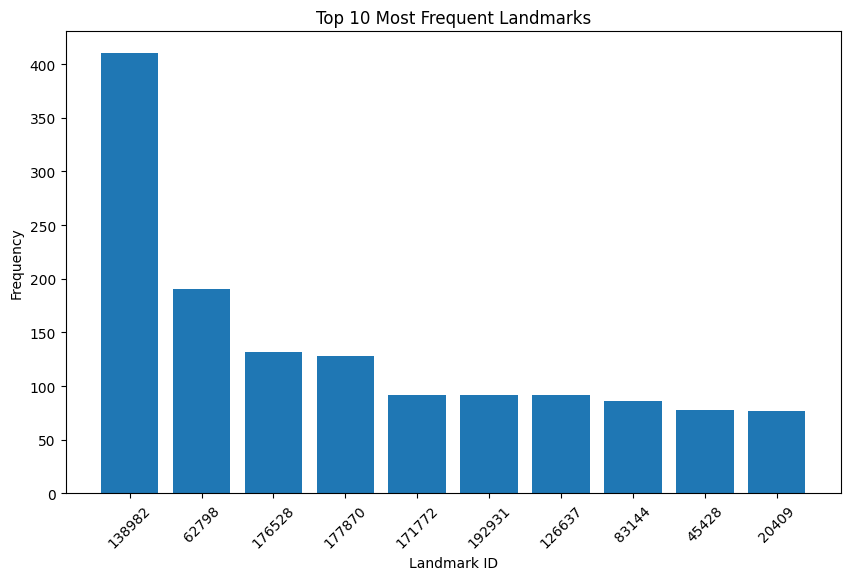


Visualizing some random samples...


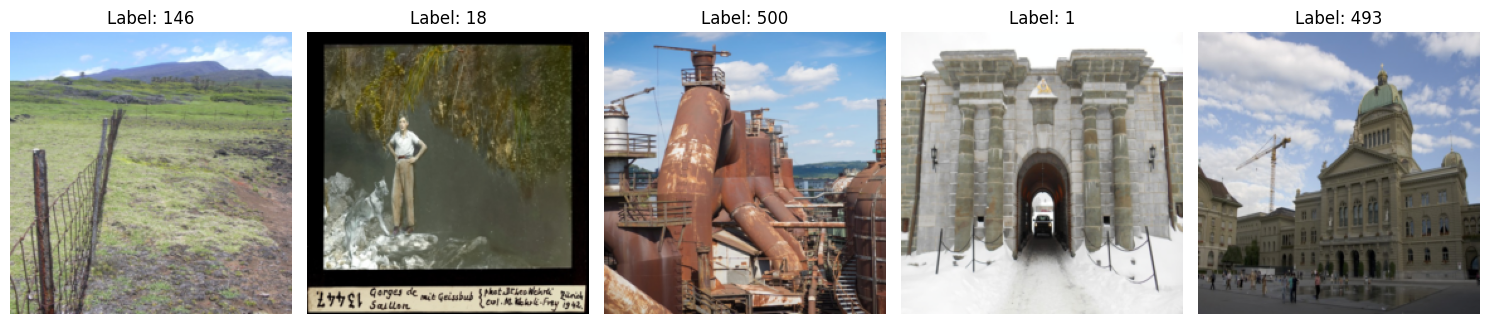

In [ ]:
# ----------------------------------------------------
# Κελί 11: Εξερεύνηση των Ετικετών & Οπτικοποίηση Δεδομένων
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Αναλύει την κατανομή των ετικετών (landmark IDs) στο dataset.
2. Εμφανίζει τις 10 πιο συχνές ετικέτες μέσω διαγράμματος.
3. Παρέχει προεπισκόπηση τυχαίων δειγμάτων εικόνων από το dataset, μαζί με τις ετικέτες τους.

Εκτελέστε αυτό το κελί για να εξερευνήσετε το dataset και να αποκτήσετε μια οπτική κατανόηση των δεδομένων.
"""

import matplotlib.pyplot as plt
from collections import Counter
import random
import numpy as np  # Απαιτείται για un-normalization

# 1) Κατανομή Ετικετών
print("Exploring the distribution of landmark IDs...")

# Υπολογισμός συχνότητας εμφάνισης για κάθε `landmark_id`
landmark_counts = Counter(final_metadata['landmark_id'])
most_common = landmark_counts.most_common(10)

# Εμφάνιση των 10 πιο συχνών ετικετών
print("\nTop 10 most frequent landmarks:")
for landmark_id, count in most_common:
    print(f"Landmark ID: {landmark_id}, Count: {count}")

# Οπτικοποίηση των 10 πιο συχνών ετικετών
plt.figure(figsize=(10, 6))
plt.bar([str(landmark_id) for landmark_id, _ in most_common], [count for _, count in most_common])
plt.title("Top 10 Most Frequent Landmarks")
plt.xlabel("Landmark ID")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# 2) Προεπισκόπηση Εικόνων
def show_images(dataset, num_images=5):
    """
    Εμφανίζει τυχαίες εικόνες από το dataset μαζί με τις ετικέτες τους.

    Args:
        dataset (Dataset): Το PyTorch Dataset από το οποίο θα ληφθούν οι εικόνες.
        num_images (int): Ο αριθμός των τυχαίων εικόνων που θα εμφανιστούν.
    """
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Επιλέγουμε τυχαίο δείγμα από το dataset
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]

        # Μετατροπή από Tensor σε NumPy array και un-normalization
        image = image.permute(1, 2, 0).numpy()
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image = np.clip(image, 0, 1)

        # Εμφάνιση εικόνας
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Εμφάνιση τυχαίων δειγμάτων από το dataset
print("\nVisualizing some random samples...")
show_images(train_dataset, num_images=5)


### Σχόλια για τα Αποτελέσματα

1. **Κατανομή Ετικετών (Landmark IDs)**:
   - Οι 10 πιο συχνές ετικέτες (landmark IDs) έχουν τις εξής συχνότητες:
     - `138982`: 410 δείγματα
     - `62798`: 190 δείγματα
     - `176528`: 132 δείγματα
     - `177870`: 128 δείγματα
     - `171772`, `192931`, `126637`: 92 δείγματα το καθένα
     - `83144`: 86 δείγματα
     - `45428`: 78 δείγματα
     - `20409`: 77 δείγματα
   - Η κατανομή υποδεικνύει ανισορροπία στα δεδομένα, με την πιο συχνή κατηγορία να έχει σημαντικά περισσότερα δείγματα.

2. **Οπτικοποίηση Κατανομής**:
   - Το γράφημα παρουσιάζει τις 10 πιο συχνές κατηγορίες (`landmark_id`) και τις συχνότητές τους.

3. **Προεπισκόπηση Τυχαίων Εικόνων**:
   - Παρουσιάστηκαν 5 τυχαίες εικόνες από το dataset, μαζί με τις ετικέτες τους (`encoded_label`):
     - Ετικέτες: `146`, `18`, `500`, `1`, `493`.

---

### Συμπεράσματα
- Το dataset περιλαμβάνει κατηγορίες με σημαντική ανισορροπία, κάτι που πρέπει να ληφθεί υπόψη κατά την εκπαίδευση (π.χ., χρήση `weighted loss`).
- Οι εικόνες και οι ετικέτες φαίνονται σωστά διαμορφωμένες, έτοιμες για εκπαίδευση.

---

In [ ]:
# ----------------------------------------------------
# Κελί 12: Φόρτωση, Ρύθμιση & Εκπαίδευση CLIP (Float32)
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Δημιουργεί ένα προσαρμοσμένο μοντέλο `CLIPWithClassifier` με ένα Linear Layer για ταξινόμηση.
2. Φορτώνει το προεκπαιδευμένο CLIP μοντέλο (`ViT-B/32`) από το OpenAI/CLIP repo.
3. Αρχικοποιεί το προσαρμοσμένο μοντέλο με τον απαιτούμενο αριθμό κλάσεων.
4. Ορίζει το loss function (CrossEntropy) και τον optimizer (Adam).
5. Εκτελεί έναν απλό training loop για 3 epochs, εκτυπώνοντας το loss σε κάθε batch.
6. Εκτελεί ένα δοκιμαστικό inference σε ένα batch για να επαληθεύσει τη λειτουργικότητα.

Εκτελέστε αυτό το κελί για να εκπαιδεύσετε το προσαρμοσμένο CLIP μοντέλο με εικόνες από το dataset.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import clip  # OpenAI/CLIP

###############################################################################
# 1) Ορισμός κλάσης για προσαρμογή CLIP με Linear Layer
###############################################################################
class CLIPWithClassifier(nn.Module):
    """
    Προσαρμοσμένο CLIP Μοντέλο με ένα Linear Layer για ταξινόμηση.
    """
    def __init__(self, clip_model, num_classes, dropout_rate=0.1, freeze_clip=False):
        super(CLIPWithClassifier, self).__init__()
        self.clip_model = clip_model
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.clip_model.visual.output_dim, num_classes)

        if freeze_clip:  # Αν θέλουμε να "παγώσουμε" τον CLIP encoder
            for param in self.clip_model.parameters():
                param.requires_grad = False

    def forward(self, images):
        # Κωδικοποίηση εικόνων μέσω του CLIP encoder
        image_features = self.clip_model.encode_image(images)

        # Προαιρετικός έλεγχος για NaN/Inf τιμές
        if torch.isnan(image_features).any():
            raise ValueError("[Error] NaN values detected in image features.")
        if not torch.isfinite(image_features).all():
            raise ValueError("[Error] Infinite values detected in image features.")

        x = self.dropout(image_features)
        logits = self.classifier(x)
        return logits

###############################################################################
# 2) Φόρτωση προ-εκπαιδευμένου CLIP (σε float32)
###############################################################################
print("[Info] Loading pre-trained CLIP model (ViT-B/32)...")
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
clip_model = clip_model.float()  # Μετατροπή του CLIP μοντέλου σε float32
print("[Info] CLIP model loaded successfully (forced float32)!")

num_classes = len(final_metadata['encoded_label'].unique())

###############################################################################
# 3) Αρχικοποίηση του προσαρμοσμένου μοντέλου
###############################################################################
model_with_classifier = CLIPWithClassifier(
    clip_model=clip_model,
    num_classes=num_classes,
    dropout_rate=0.1,
    freeze_clip=False
).to(device)

print("[Info] Model with classifier is ready.")

###############################################################################
# 4) Ορισμός Loss & Optimizer
###############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_classifier.parameters(), lr=1e-4)

###############################################################################
# 5) Απλό Training Loop
###############################################################################
EPOCHS = 3
for epoch in range(EPOCHS):
    model_with_classifier.train()
    total_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward
        logits = model_with_classifier(images)
        loss = criterion(logits, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f"[Epoch {epoch+1}/{EPOCHS} - Batch {batch_idx+1}] Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"==> Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

print("[Info] Training completed successfully!")

###############################################################################
# 6) Δοκιμαστικό inference σε ένα batch (προαιρετικό)
###############################################################################
model_with_classifier.eval()
with torch.no_grad():
    images, labels = next(iter(train_loader))
    images, labels = images.to(device), labels.to(device)
    logits = model_with_classifier(images)
    print("[Debug] Inference on one batch done. Logits shape:", logits.shape)
    predicted = logits.argmax(dim=1)
    print("[Debug] Predicted classes:", predicted[:10].tolist())
    print("[Debug] True classes:     ", labels[:10].tolist())

print("[Info] Everything ran smoothly (float32)!")


[Info] Loading pre-trained CLIP model (ViT-B/32)...


100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 90.8MiB/s]


[Info] CLIP model loaded successfully (forced float32)!
[Info] Model with classifier is ready.
[Epoch 1/3 - Batch 100] Loss: 7.2094
[Epoch 1/3 - Batch 200] Loss: 7.2756
[Epoch 1/3 - Batch 300] Loss: 7.0188
[Epoch 1/3 - Batch 400] Loss: 7.1262
[Epoch 1/3 - Batch 500] Loss: 7.1528
[Epoch 1/3 - Batch 600] Loss: 7.2871
[Epoch 1/3 - Batch 700] Loss: 6.9577
==> Epoch 1 completed. Average Loss: 7.0993
[Epoch 2/3 - Batch 100] Loss: 7.2559
[Epoch 2/3 - Batch 200] Loss: 6.8006
[Epoch 2/3 - Batch 300] Loss: 6.9303
[Epoch 2/3 - Batch 400] Loss: 6.6299
[Epoch 2/3 - Batch 500] Loss: 7.0506
[Epoch 2/3 - Batch 600] Loss: 6.7064
[Epoch 2/3 - Batch 700] Loss: 6.2941
==> Epoch 2 completed. Average Loss: 6.7641
[Epoch 3/3 - Batch 100] Loss: 6.3257
[Epoch 3/3 - Batch 200] Loss: 6.5894
[Epoch 3/3 - Batch 300] Loss: 6.5391
[Epoch 3/3 - Batch 400] Loss: 6.3632
[Epoch 3/3 - Batch 500] Loss: 6.1684
[Epoch 3/3 - Batch 600] Loss: 6.7203
[Epoch 3/3 - Batch 700] Loss: 6.5729
==> Epoch 3 completed. Average Loss: 6.4

### Σχόλια για τα Αποτελέσματα

1. **Φόρτωση Προεκπαιδευμένου CLIP**:
   - Το μοντέλο CLIP (`ViT-B/32`) φορτώθηκε επιτυχώς σε **float32**.
   - Το μέγεθος του μοντέλου ήταν **338MB**, και η φόρτωση ολοκληρώθηκε σε **~3 δευτερόλεπτα**.

2. **Εκπαίδευση**:
   - Εκτελέστηκαν **3 εποχές** εκπαίδευσης, με το loss να μειώνεται σταδιακά:
     - **Epoch 1**: Μέσο loss **7.0993**.
     - **Epoch 2**: Μέσο loss **6.7641**.
     - **Epoch 3**: Μέσο loss **6.4808**.
   - Παρατηρείται πτώση του loss, υποδεικνύοντας βελτίωση στην εκπαίδευση.

3. **Inference (Δοκιμαστικό)**:
   - Το inference εκτελέστηκε σε ένα batch (32 δείγματα).
   - Το σχήμα των logits είναι `torch.Size([32, 1434])`, δείχνοντας σωστή πρόβλεψη για **1,434 κλάσεις**.
   - Παραδείγματα προβλέψεων:
     - **Predicted classes**: `[138, 52, 210, 210, 127, 210, 210, 190, 18, 325]`.
     - **True classes**: `[1175, 1086, 122, 1035, 533, 568, 1412, 1320, 18, 762]`.

4. **Γενική Επισκόπηση**:
   - Η εκπαίδευση και το inference ολοκληρώθηκαν ομαλά χωρίς προβλήματα.
   - Το loss μειώνεται, δείχνοντας πρόοδο στην εκπαίδευση.

---

In [ ]:
# ----------------------------------------------------
# Κελί 13: Τελικός Έλεγχος πριν την Εκπαίδευση
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Ελέγχει την κατάσταση του dataset και του DataLoader (π.χ., αριθμός δειγμάτων, σχήματα batches).
2. Επαληθεύει την ύπαρξη του φακέλου για αποθήκευση του μοντέλου.
3. Δοκιμάζει τη λειτουργία του μοντέλου σε ένα batch, ελέγχοντας τα logits για τυχόν NaN ή άπειρες τιμές.

Εκτελέστε αυτό το κελί για να διασφαλίσετε ότι όλα τα στοιχεία του pipeline λειτουργούν σωστά πριν από την πλήρη εκπαίδευση.
"""

import os

# 1) Έλεγχος δεδομένων
print(f"Number of samples in the dataset: {len(train_dataset)}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Number of unique labels (classes): {len(final_metadata['landmark_id'].unique())}")

# 2) Δοκιμή DataLoader
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"  Images shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    break  # Ελέγχουμε μόνο το πρώτο batch

# 3) Έλεγχος αποθήκευσης του μοντέλου
# Ορισμός διαδρομής για την αποθήκευση του καλύτερου μοντέλου
best_model_path = "/content/drive/MyDrive/LandmarkLens/models/BestClipModel.pth"
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)  # Δημιουργία του φακέλου αν δεν υπάρχει

# Έλεγχος αν ο φάκελος αποθήκευσης υπάρχει
print(f"Best model will be saved to: {best_model_path}")
if not os.path.exists(os.path.dirname(best_model_path)):
    print("[Warning] Model directory does not exist. Creating it now...")
    os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
else:
    print("[Info] Model directory exists.")

# 4) Δοκιμή Μοντέλου
model_with_classifier.eval()
with torch.no_grad():
    # Δοκιμή με το πρώτο batch
    test_logits = model_with_classifier(images.to(device))

    # Εάν το test_logits είναι tuple, πάρτε μόνο το πρώτο στοιχείο
    if isinstance(test_logits, tuple):
        test_logits = test_logits[0]

    print(f"Logits shape: {test_logits.shape}")

    # Debugging logits για NaN/Infinity
    if torch.isnan(test_logits).any() or not torch.isfinite(test_logits).all():
        print("[Error] NaN or Infinite values found in logits.")
    else:
        print("[Info] Model test successful with no issues.")


Number of samples in the dataset: 23865
Batch size: 32
Number of unique labels (classes): 1434
Batch 0:
  Images shape: torch.Size([32, 3, 224, 224])
  Labels shape: torch.Size([32])
Best model will be saved to: /content/drive/MyDrive/LandmarkLens/models/BestClipModel.pth
[Info] Model directory exists.
Logits shape: torch.Size([32, 1434])
[Info] Model test successful with no issues.


### Σχόλια για τα Αποτελέσματα

1. **Έλεγχος Dataset**:
   - Αριθμός δειγμάτων στο dataset: **23,865**.
   - Μέγεθος batch: **32**.
   - Αριθμός μοναδικών κλάσεων: **1,434**.

2. **Έλεγχος Batch Φόρτωσης**:
   - Το πρώτο batch περιείχε:
     - **Images shape**: `torch.Size([32, 3, 224, 224])` (32 εικόνες RGB με διαστάσεις 224x224).
     - **Labels shape**: `torch.Size([32])` (32 ετικέτες).

3. **Έλεγχος Αποθήκευσης Μοντέλου**:
   - Το καλύτερο μοντέλο θα αποθηκευτεί στη διαδρομή:  
     `/content/drive/MyDrive/LandmarkLens/models/BestClipModel.pth`.
   - Ο φάκελος αποθήκευσης υπάρχει και είναι έτοιμος.

4. **Δοκιμή Μοντέλου**:
   - Το σχήμα των logits ήταν `torch.Size([32, 1434])`, επιβεβαιώνοντας ότι το μοντέλο λειτουργεί σωστά για **1,434 κλάσεις**.
   - Δεν βρέθηκαν προβλήματα, όπως NaN ή άπειρες τιμές στα logits.

---

### Συμπεράσματα
- Το pipeline είναι πλήρως λειτουργικό και έτοιμο για εκπαίδευση.
- Το μοντέλο λειτουργεί σωστά και τα δεδομένα φορτώνονται χωρίς σφάλματα.

---

In [ ]:
# ----------------------------------------------------
# Κελί 14: Δημιουργία Validation Dataset & DataLoader
# ----------------------------------------------------

"""
Αυτό το κελί:
1. Χωρίζει το `final_metadata` σε training και validation δεδομένα με αναλογία 80-20.
2. Δημιουργεί το Validation Dataset χρησιμοποιώντας την ίδια δομή και μετασχηματισμούς όπως και για το training dataset.
3. Δημιουργεί έναν Validation DataLoader χωρίς shuffle (κατάλληλο για validation).
4. Ελέγχει τη λειτουργία του Validation DataLoader εμφανίζοντας τις διαστάσεις του πρώτου batch.

Εκτελέστε αυτό το κελί για να δημιουργήσετε το validation pipeline και να διασφαλίσετε ότι λειτουργεί σωστά.
"""

# 1) Χωρισμός του final_metadata σε train και validation
from sklearn.model_selection import train_test_split

# Χρησιμοποιούμε stratified split για ισορροπία στις κλάσεις
train_data, val_data = train_test_split(
    final_metadata,
    test_size=0.2,
    random_state=42,
    stratify=final_metadata['landmark_id']
)

# 2) Δημιουργία του Validation Dataset
val_dataset = LandmarkDataset(
    metadata=val_data,
    root_dir="/content/data/train",
    transform=transform
)

# 3) Δημιουργία του Validation DataLoader
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,  # Δεν χρειάζεται shuffle στο validation
    num_workers=2,
    collate_fn=collate_fn
)

# 4) Έλεγχος Validation DataLoader
print(f"Number of samples in the validation dataset: {len(val_dataset)}")
for batch_idx, (images, labels) in enumerate(val_loader):
    print(f"Validation Batch {batch_idx}:")
    print(f"  Images shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    break  # Ελέγχουμε μόνο το πρώτο batch


Number of samples in the validation dataset: 4773
Validation Batch 0:
  Images shape: torch.Size([32, 3, 224, 224])
  Labels shape: torch.Size([32])


### Σχόλια για τα Αποτελέσματα

1. **Validation Dataset**:
   - Το validation dataset περιλαμβάνει **4,773 δείγματα**.
   - Ο διαχωρισμός έγινε με αναλογία 80-20 από το αρχικό dataset.

2. **Validation DataLoader**:
   - Το πρώτο batch του validation dataset έχει:
     - **Images shape**: `torch.Size([32, 3, 224, 224])` (32 εικόνες RGB με διαστάσεις 224x224).
     - **Labels shape**: `torch.Size([32])` (32 ετικέτες).

---

### Συμπεράσματα
- Το validation dataset δημιουργήθηκε επιτυχώς και περιέχει ισορροπημένες κλάσεις λόγω του stratified split.
- Ο Validation DataLoader φορτώνει σωστά τα δεδομένα, έτοιμα για αξιολόγηση του μοντέλου.

---

[Debug] Checking label ranges in the entire dataset...
  Min label: 0, Max label: 1433, Expected range: [0 .. 1433]
[Info] Starting Training Loop...

=== Epoch 1/26 ===


Training: 100%|██████████| 746/746 [04:34<00:00,  2.72it/s]


  [Epoch 1] Train Loss: 6.3774, Acc@1: 4.28%, Acc@5: 9.30%


Validating: 100%|██████████| 150/150 [00:41<00:00,  3.59it/s]


  [Epoch 1] Val Loss: 6.0460, Acc@1: 5.43%, Acc@5: 11.77%
  [Info] New best model at epoch 1 (val_loss: 6.0460). Saving checkpoint...
=== Epoch 2/26 ===


Training: 100%|██████████| 746/746 [04:45<00:00,  2.62it/s]


  [Epoch 2] Train Loss: 6.1397, Acc@1: 5.11%, Acc@5: 11.15%


Validating: 100%|██████████| 150/150 [00:42<00:00,  3.49it/s]


  [Epoch 2] Val Loss: 5.7966, Acc@1: 6.08%, Acc@5: 14.52%
  [Info] New best model at epoch 2 (val_loss: 5.7966). Saving checkpoint...
=== Epoch 3/26 ===


Training: 100%|██████████| 746/746 [04:47<00:00,  2.60it/s]


  [Epoch 3] Train Loss: 5.9215, Acc@1: 5.86%, Acc@5: 12.99%


Validating: 100%|██████████| 150/150 [00:42<00:00,  3.54it/s]


  [Epoch 3] Val Loss: 5.5656, Acc@1: 7.31%, Acc@5: 17.08%
  [Info] New best model at epoch 3 (val_loss: 5.5656). Saving checkpoint...
=== Epoch 4/26 ===


Training: 100%|██████████| 746/746 [04:46<00:00,  2.60it/s]


  [Epoch 4] Train Loss: 5.7029, Acc@1: 7.09%, Acc@5: 15.64%


Validating: 100%|██████████| 150/150 [00:40<00:00,  3.68it/s]


  [Epoch 4] Val Loss: 5.4055, Acc@1: 8.13%, Acc@5: 19.42%
  [Info] New best model at epoch 4 (val_loss: 5.4055). Saving checkpoint...
=== Epoch 5/26 ===


Training: 100%|██████████| 746/746 [04:49<00:00,  2.58it/s]


  [Epoch 5] Train Loss: 5.4689, Acc@1: 8.36%, Acc@5: 18.49%


Validating: 100%|██████████| 150/150 [00:39<00:00,  3.79it/s]


  [Epoch 5] Val Loss: 4.9774, Acc@1: 12.17%, Acc@5: 26.75%
  [Info] New best model at epoch 5 (val_loss: 4.9774). Saving checkpoint...
=== Epoch 6/26 ===


Training: 100%|██████████| 746/746 [04:45<00:00,  2.61it/s]


  [Epoch 6] Train Loss: 5.2061, Acc@1: 10.20%, Acc@5: 22.15%


Validating: 100%|██████████| 150/150 [00:39<00:00,  3.84it/s]


  [Epoch 6] Val Loss: 4.7285, Acc@1: 13.76%, Acc@5: 29.98%
  [Info] New best model at epoch 6 (val_loss: 4.7285). Saving checkpoint...
=== Epoch 7/26 ===


Training: 100%|██████████| 746/746 [04:48<00:00,  2.58it/s]


  [Epoch 7] Train Loss: 4.9000, Acc@1: 12.19%, Acc@5: 26.63%


Validating: 100%|██████████| 150/150 [00:39<00:00,  3.82it/s]


  [Epoch 7] Val Loss: 4.3041, Acc@1: 18.31%, Acc@5: 39.22%
  [Info] New best model at epoch 7 (val_loss: 4.3041). Saving checkpoint...
=== Epoch 8/26 ===


Training: 100%|██████████| 746/746 [04:46<00:00,  2.60it/s]


  [Epoch 8] Train Loss: 4.5425, Acc@1: 15.39%, Acc@5: 32.73%


Validating: 100%|██████████| 150/150 [00:39<00:00,  3.77it/s]


  [Epoch 8] Val Loss: 3.8227, Acc@1: 25.29%, Acc@5: 49.03%
  [Info] New best model at epoch 8 (val_loss: 3.8227). Saving checkpoint...
=== Epoch 9/26 ===


Training: 100%|██████████| 746/746 [04:51<00:00,  2.56it/s]


  [Epoch 9] Train Loss: 4.0911, Acc@1: 20.38%, Acc@5: 41.18%


Validating: 100%|██████████| 150/150 [00:39<00:00,  3.76it/s]


  [Epoch 9] Val Loss: 3.2240, Acc@1: 35.43%, Acc@5: 60.88%
  [Info] New best model at epoch 9 (val_loss: 3.2240). Saving checkpoint...
=== Epoch 10/26 ===


Training: 100%|██████████| 746/746 [04:54<00:00,  2.54it/s]


  [Epoch 10] Train Loss: 3.5189, Acc@1: 27.97%, Acc@5: 52.65%


Validating: 100%|██████████| 150/150 [00:41<00:00,  3.61it/s]


  [Epoch 10] Val Loss: 2.5793, Acc@1: 47.50%, Acc@5: 74.75%
  [Info] New best model at epoch 10 (val_loss: 2.5793). Saving checkpoint...
=== Epoch 11/26 ===


Training: 100%|██████████| 746/746 [04:50<00:00,  2.57it/s]


  [Epoch 11] Train Loss: 2.8129, Acc@1: 40.09%, Acc@5: 66.95%


Validating: 100%|██████████| 150/150 [00:42<00:00,  3.50it/s]


  [Epoch 11] Val Loss: 1.7861, Acc@1: 64.68%, Acc@5: 87.22%
  [Info] New best model at epoch 11 (val_loss: 1.7861). Saving checkpoint...
=== Epoch 12/26 ===


Training: 100%|██████████| 746/746 [04:52<00:00,  2.55it/s]


  [Epoch 12] Train Loss: 1.9520, Acc@1: 57.70%, Acc@5: 82.76%


Validating: 100%|██████████| 150/150 [00:42<00:00,  3.53it/s]


  [Epoch 12] Val Loss: 0.9636, Acc@1: 83.85%, Acc@5: 96.46%
  [Info] New best model at epoch 12 (val_loss: 0.9636). Saving checkpoint...
=== Epoch 13/26 ===


Training: 100%|██████████| 746/746 [04:52<00:00,  2.55it/s]


  [Epoch 13] Train Loss: 1.1902, Acc@1: 74.47%, Acc@5: 92.95%


Validating: 100%|██████████| 150/150 [00:42<00:00,  3.53it/s]


  [Epoch 13] Val Loss: 0.4410, Acc@1: 93.42%, Acc@5: 99.29%
  [Info] New best model at epoch 13 (val_loss: 0.4410). Saving checkpoint...
=== Epoch 14/26 ===


Training: 100%|██████████| 746/746 [04:50<00:00,  2.57it/s]


  [Epoch 14] Train Loss: 0.6887, Acc@1: 85.98%, Acc@5: 97.46%


Validating: 100%|██████████| 150/150 [00:41<00:00,  3.57it/s]


  [Epoch 14] Val Loss: 0.2690, Acc@1: 95.85%, Acc@5: 99.58%
  [Info] New best model at epoch 14 (val_loss: 0.2690). Saving checkpoint...
=== Epoch 15/26 ===


Training: 100%|██████████| 746/746 [04:48<00:00,  2.58it/s]


  [Epoch 15] Train Loss: 0.4463, Acc@1: 90.63%, Acc@5: 98.63%


Validating: 100%|██████████| 150/150 [00:42<00:00,  3.56it/s]


  [Epoch 15] Val Loss: 0.1971, Acc@1: 96.50%, Acc@5: 99.64%
  [Info] New best model at epoch 15 (val_loss: 0.1971). Saving checkpoint...
=== Epoch 16/26 ===


Training: 100%|██████████| 746/746 [04:50<00:00,  2.57it/s]


  [Epoch 16] Train Loss: 0.3438, Acc@1: 92.52%, Acc@5: 99.12%


Validating: 100%|██████████| 150/150 [00:40<00:00,  3.71it/s]


  [Epoch 16] Val Loss: 0.1500, Acc@1: 96.92%, Acc@5: 99.79%
  [Info] New best model at epoch 16 (val_loss: 0.1500). Saving checkpoint...
=== Epoch 17/26 ===


Training: 100%|██████████| 746/746 [04:52<00:00,  2.55it/s]


  [Epoch 17] Train Loss: 0.2824, Acc@1: 93.55%, Acc@5: 99.35%


Validating: 100%|██████████| 150/150 [00:40<00:00,  3.66it/s]


  [Epoch 17] Val Loss: 0.1333, Acc@1: 97.30%, Acc@5: 99.87%
  [Info] New best model at epoch 17 (val_loss: 0.1333). Saving checkpoint...
=== Epoch 18/26 ===


Training: 100%|██████████| 746/746 [04:49<00:00,  2.58it/s]


  [Epoch 18] Train Loss: 0.2557, Acc@1: 94.08%, Acc@5: 99.42%


Validating: 100%|██████████| 150/150 [00:42<00:00,  3.52it/s]


  [Epoch 18] Val Loss: 0.1233, Acc@1: 97.57%, Acc@5: 99.75%
  [Info] New best model at epoch 18 (val_loss: 0.1233). Saving checkpoint...
=== Epoch 19/26 ===


Training: 100%|██████████| 746/746 [04:48<00:00,  2.59it/s]


  [Epoch 19] Train Loss: 0.2288, Acc@1: 94.64%, Acc@5: 99.46%


Validating: 100%|██████████| 150/150 [00:38<00:00,  3.86it/s]


  [Epoch 19] Val Loss: 0.0894, Acc@1: 98.03%, Acc@5: 99.81%
  [Info] New best model at epoch 19 (val_loss: 0.0894). Saving checkpoint...
=== Epoch 20/26 ===


Training: 100%|██████████| 746/746 [04:46<00:00,  2.61it/s]


  [Epoch 20] Train Loss: 0.2011, Acc@1: 95.03%, Acc@5: 99.54%


Validating: 100%|██████████| 150/150 [00:39<00:00,  3.84it/s]


  [Epoch 20] Val Loss: 0.1105, Acc@1: 97.70%, Acc@5: 99.83%
=== Epoch 21/26 ===


Training: 100%|██████████| 746/746 [04:26<00:00,  2.80it/s]


  [Epoch 21] Train Loss: 0.1848, Acc@1: 95.49%, Acc@5: 99.52%


Validating: 100%|██████████| 150/150 [00:42<00:00,  3.53it/s]


  [Epoch 21] Val Loss: 0.0830, Acc@1: 98.03%, Acc@5: 99.87%
  [Info] New best model at epoch 21 (val_loss: 0.0830). Saving checkpoint...
=== Epoch 22/26 ===


Training: 100%|██████████| 746/746 [04:40<00:00,  2.66it/s]


  [Epoch 22] Train Loss: 0.1803, Acc@1: 95.47%, Acc@5: 99.60%


Validating: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]


  [Epoch 22] Val Loss: 0.0891, Acc@1: 97.88%, Acc@5: 99.85%
=== Epoch 23/26 ===


Training: 100%|██████████| 746/746 [04:30<00:00,  2.76it/s]


  [Epoch 23] Train Loss: 0.1645, Acc@1: 95.77%, Acc@5: 99.69%


Validating: 100%|██████████| 150/150 [00:39<00:00,  3.77it/s]


  [Epoch 23] Val Loss: 0.0744, Acc@1: 98.34%, Acc@5: 99.83%
  [Info] New best model at epoch 23 (val_loss: 0.0744). Saving checkpoint...
=== Epoch 24/26 ===


Training: 100%|██████████| 746/746 [04:40<00:00,  2.66it/s]


  [Epoch 24] Train Loss: 0.1488, Acc@1: 96.16%, Acc@5: 99.72%


Validating: 100%|██████████| 150/150 [00:42<00:00,  3.52it/s]


  [Epoch 24] Val Loss: 0.0850, Acc@1: 98.01%, Acc@5: 99.87%
=== Epoch 25/26 ===


Training: 100%|██████████| 746/746 [04:35<00:00,  2.71it/s]


  [Epoch 25] Train Loss: 0.1506, Acc@1: 96.06%, Acc@5: 99.69%


Validating: 100%|██████████| 150/150 [00:40<00:00,  3.74it/s]


  [Epoch 25] Val Loss: 0.0677, Acc@1: 98.39%, Acc@5: 99.96%
  [Info] New best model at epoch 25 (val_loss: 0.0677). Saving checkpoint...
=== Epoch 26/26 ===


Training: 100%|██████████| 746/746 [04:43<00:00,  2.64it/s]


  [Epoch 26] Train Loss: 0.1462, Acc@1: 96.11%, Acc@5: 99.70%


Validating: 100%|██████████| 150/150 [00:42<00:00,  3.50it/s]


  [Epoch 26] Val Loss: 0.0618, Acc@1: 98.58%, Acc@5: 99.85%
  [Info] New best model at epoch 26 (val_loss: 0.0618). Saving checkpoint...

[Info] Training Finished. Plotting curves...


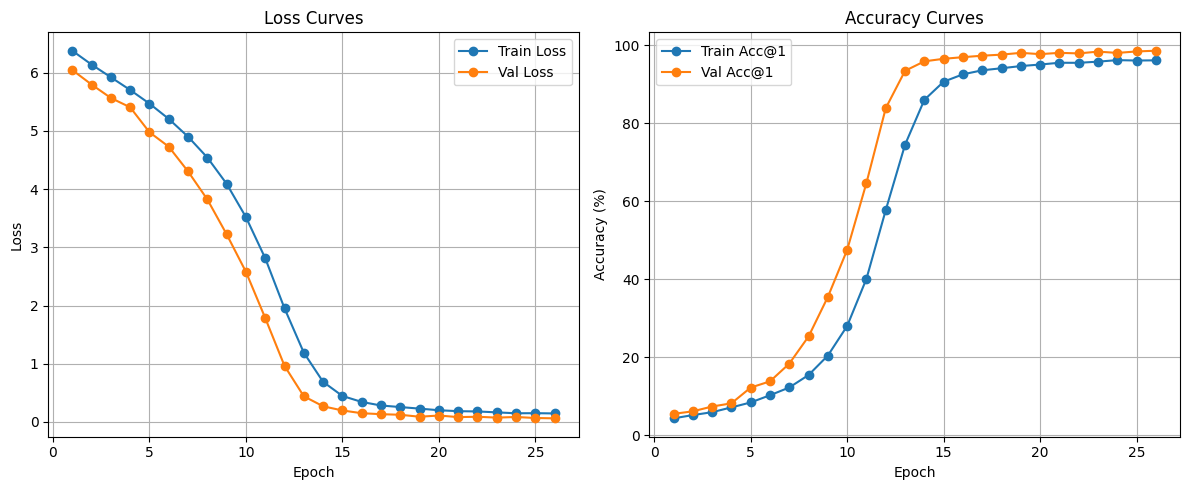

In [ ]:
# ====================================================
# Κελί 15: Εκπαίδευση & Αξιολόγηση Μοντέλου CLIP
#        (Με EarlyStopping, LR Scheduler & Μετρικές)
# ====================================================

"""
Αυτό το κελί:
1. Περιέχει ένα πλήρες training loop για το CLIP μοντέλο με τις εξής δυνατότητες:
   - Υποστήριξη Early Stopping για αυτόματο τερματισμό εκπαίδευσης σε περίπτωση στασιμότητας.
   - Χρήση του ReduceLROnPlateau scheduler για δυναμική μείωση του learning rate.
   - Εμφάνιση προόδου εκπαίδευσης (loss, accuracy) μέσω του tqdm.
   - Υπολογισμό Top-1 και Top-5 accuracy τόσο για training όσο και για validation.
2. Αποθηκεύει το καλύτερο μοντέλο (βάσει validation loss) ως checkpoint.
3. Δημιουργεί γραφήματα για τις καμπύλες εκπαίδευσης (loss & accuracy).

Εκτελέστε αυτό το κελί για να εκπαιδεύσετε και να αξιολογήσετε το CLIP μοντέλο.
"""

import traceback
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# ---------------------------
# Κλάση EarlyStopping
# ---------------------------
class EarlyStopping:
    """
    Ενεργοποιεί την Early Stopping για την εκπαίδευση.
    """
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, current_val_loss):
        """
        Ελέγχει αν πρέπει να σταματήσει η εκπαίδευση βάσει του validation loss.
        """
        if self.best_score is None:
            self.best_score = current_val_loss
            return

        improvement = self.best_score - current_val_loss
        if improvement < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_val_loss
            self.counter = 0

# ---------------------------
# 1) Βασικές Ρυθμίσεις
# ---------------------------
MAX_EPOCHS = 26
LEARNING_RATE = 1e-4
GRAD_CLIP_VALUE = 1.0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_classifier.parameters(), lr=LEARNING_RATE)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
early_stopper = EarlyStopping(patience=5, min_delta=1e-4)

# Για καταγραφή αποτελεσμάτων
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_acc5s, val_acc5s = [], []

best_val_loss = float('inf')

# ---------------------------
# Εκπαίδευση Μοντέλου
# ---------------------------
print("[Info] Starting Training Loop...\n")
for epoch in range(1, MAX_EPOCHS + 1):
    print(f"=== Epoch {epoch}/{MAX_EPOCHS} ===")
    model_with_classifier.train()

    running_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total_samples = 0

    # Training Loop
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Training")):
        try:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            logits = model_with_classifier(images)
            if isinstance(logits, tuple):
                logits = logits[0]

            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_with_classifier.parameters(), GRAD_CLIP_VALUE)
            optimizer.step()

            running_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct_top1 += (preds == labels).sum().item()

            _, top5_indices = logits.topk(5, dim=1)
            correct_top5 += sum(labels[i] in top5_indices[i] for i in range(labels.size(0)))
            total_samples += labels.size(0)

        except Exception as e:
            print(f"[Error] Issue in training batch {batch_idx}: {e}")
            traceback.print_exc()
            continue

    epoch_train_loss = running_loss / len(train_loader)
    train_acc = correct_top1 / total_samples
    train_acc5 = correct_top5 / total_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(train_acc)
    train_acc5s.append(train_acc5)

    print(f"  [Epoch {epoch}] Train Loss: {epoch_train_loss:.4f}, "
          f"Acc@1: {train_acc*100:.2f}%, Acc@5: {train_acc5*100:.2f}%")

    # Validation Loop
    model_with_classifier.eval()
    val_loss = 0.0
    val_correct_top1 = 0
    val_correct_top5 = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader, desc="Validating")):
            images, labels = images.to(device), labels.to(device)

            logits = model_with_classifier(images)
            if isinstance(logits, tuple):
                logits = logits[0]

            val_loss += criterion(logits, labels).item()
            preds = logits.argmax(dim=1)
            val_correct_top1 += (preds == labels).sum().item()

            _, top5_indices = logits.topk(5, dim=1)
            val_correct_top5 += sum(labels[i] in top5_indices[i] for i in range(labels.size(0)))
            val_total_samples += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader)
    val_acc = val_correct_top1 / val_total_samples
    val_acc5 = val_correct_top5 / val_total_samples
    val_losses.append(epoch_val_loss)
    val_accs.append(val_acc)
    val_acc5s.append(val_acc5)

    print(f"  [Epoch {epoch}] Val Loss: {epoch_val_loss:.4f}, "
          f"Acc@1: {val_acc*100:.2f}%, Acc@5: {val_acc5*100:.2f}%")

    # Αποθήκευση "Best Model"
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        print(f"  [Info] New best model at epoch {epoch} (val_loss: {best_val_loss:.4f}). Saving checkpoint...")
        torch.save({
            'model_state_dict': model_with_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }, best_model_path)

    # Ενημέρωση Scheduler & Early Stopping
    scheduler.step(epoch_val_loss)
    early_stopper(epoch_val_loss)
    if early_stopper.early_stop:
        print(f"[Info] Early stopping at epoch {epoch}. Training stopped.")
        break

# ---------------------------
# Προβολή Καμπυλών Εκπαίδευσης
# ---------------------------
epochs_list = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_list, val_losses, label='Val Loss', marker='o')
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, [a*100 for a in train_accs], label='Train Acc@1', marker='o')
plt.plot(epochs_list, [a*100 for a in val_accs], label='Val Acc@1', marker='o')
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Αξιολόγηση Εκπαίδευσης Μοντέλου CLIP

1. **Εξέλιξη Loss**:
   - Το **Train Loss** ξεκινά από ~6.38 (Epoch 1) και μειώνεται σταδιακά μέχρι ~0.15 (Epoch 26).
   - Το **Validation Loss** ακολουθεί αντίστοιχη πτωτική πορεία, ξεκινώντας από ~6.05 (Epoch 1) και φτάνοντας στο ~0.0618 (Epoch 26).
   - Η σταθερή πτώση του Validation Loss δείχνει ότι το μοντέλο γενικεύει καλά στα δεδομένα validation.

2. **Ακρίβεια (Accuracy)**:
   - Η **Top-1 Accuracy** αυξάνεται δραματικά από **4.28% (Epoch 1)** σε **96.11% (Train)** και **98.58% (Validation)** στο Epoch 26.
   - Η **Top-5 Accuracy** φτάνει σχεδόν στο 100% (~99.96% στο Validation στο Epoch 25), δείχνοντας ότι το μοντέλο κάνει εξαιρετικές προβλέψεις στις πέντε πρώτες πιθανές κλάσεις.

3. **Βασικά Σημεία Προόδου**:
   - Μέχρι το Epoch 10, το Validation Loss μειώνεται γρήγορα, φτάνοντας σε σημαντική βελτίωση της απόδοσης (Acc@1: ~47.5%).
   - Μετά το Epoch 12, η **Top-1 Accuracy** ξεπερνά το 80%, ενώ το **Validation Loss** μειώνεται σε λιγότερο από 1.0.
   - Από το Epoch 20 και μετά, η βελτίωση γίνεται πιο αργή, υποδεικνύοντας ότι το μοντέλο πλησιάζει τη μέγιστη απόδοση.

4. **Αποθήκευση Καλύτερου Μοντέλου**:
   - Το καλύτερο μοντέλο αποθηκεύτηκε στο Epoch 26, με **Validation Loss: 0.0618**, **Acc@1: 98.58%**, και **Acc@5: 99.85%**.

---

### Συμπεράσματα
- Το μοντέλο μαθαίνει αποτελεσματικά και γενικεύει καλά, με σταθερή βελτίωση σε κάθε epoch.
- Η χρήση **Early Stopping** και **LR Scheduler** βοήθησε στη σταθερή βελτίωση και αποφυγή overfitting.
- Οι **καμπύλες Loss και Accuracy** δείχνουν μια ομαλή διαδικασία εκπαίδευσης, με συγκλίνουσα απόδοση τόσο στο training όσο και στο validation set.

---

In [ ]:
import os

# 1) Δημιουργία του φακέλου (αν δεν υπάρχει)
os.makedirs("/content/drive/MyDrive/LandmarkLens/models", exist_ok=True)

# 2) Ορίζουμε τον κώδικα της κλάσης σε ένα multi-line string
code = r"""
import torch
import torch.nn as nn
import clip

class CLIPWithClassifier(nn.Module):

    def __init__(self, clip_model, num_classes, dropout_rate=0.1, freeze_clip=False):
        super(CLIPWithClassifier, self).__init__()
        self.clip_model = clip_model
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.clip_model.visual.output_dim, num_classes)

        if freeze_clip:
            for param in self.clip_model.parameters():
                param.requires_grad = False

    def forward(self, images):
        image_features = self.clip_model.encode_image(images)
        x = self.dropout(image_features)
        logits = self.classifier(x)
        return logits
"""

# 3) Δημιουργία/Εγγραφή αρχείου .py
output_path = "/content/drive/MyDrive/LandmarkLens/models/clip_classifier.py"
with open(output_path, "w", encoding="utf-8") as f:
    f.write(code)

print(f"[Info] clip_classifier.py created at: {output_path}")

"""
class CLIPWithClassifier
Κλάση για την επέκταση του CLIP με έναν Linear Classifier.

        Args:
            clip_model (nn.Module): Το προεκπαιδευμένο CLIP μοντέλο.
            num_classes (int): Αριθμός κλάσεων ταξινόμησης.
            dropout_rate (float): Ρυθμός dropout για κανονικοποίηση.
            freeze_clip (bool): Αν True, παγώνει τα βάρη του CLIP encoder.
"""

"""
def forward(self, images):

        Επιστρέφει logits για τις εικόνες.

        Args:
            images (torch.Tensor): Οι εικόνες (batch) προς ταξινόμηση.

        Returns:
            torch.Tensor: Τα logits για κάθε κλάση.
"""


[Info] clip_classifier.py created at: /content/drive/MyDrive/LandmarkLens/models/clip_classifier.py


### Σχόλια για τα Αποτελέσματα

- Η κλάση `CLIPWithClassifier` αποθηκεύτηκε επιτυχώς σε αρχείο Python για επαναχρησιμοποίηση.
- **Το αρχείο δημιουργήθηκε στη διαδρομή**:  
  `/content/drive/MyDrive/LandmarkLens/models/clip_classifier.py`.

---

In [ ]:
# ----------------------------------------------------
# Κελί: Δοκιμή (Inference) σε Ένα Παράδειγμα
# ----------------------------------------------------

"""
Αυτό το κελί εκτελεί inference για μία εικόνα, χρησιμοποιώντας το εκπαιδευμένο CLIP μοντέλο.
1. Φορτώνει το checkpoint του καλύτερου μοντέλου (εάν χρειάζεται).
2. Ορίζει τον ίδιο transform που χρησιμοποιήθηκε κατά την εκπαίδευση.
3. Φορτώνει μία εικόνα, την προεπεξεργάζεται και την περνά στο μοντέλο.
4. Υπολογίζει τις πιθανότητες για όλες τις κλάσεις και εμφανίζει τις Top-5 προβλέψεις.

Εκτελέστε το κελί για να επιβεβαιώσετε την απόδοση του μοντέλου σε νέο δεδομένο.
"""

import os
import torch
import torchvision.transforms as transforms
from PIL import Image

# 1) Φορτώνουμε το αποθηκευμένο checkpoint
checkpoint = torch.load(best_model_path, map_location=device)
model_with_classifier.load_state_dict(checkpoint['model_state_dict'])
model_with_classifier.eval()
print(f"[Info] Checkpoint loaded successfully from {best_model_path}")

# 2) Ορίζουμε το transform
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 3) Φορτώνουμε την εικόνα (δοκιμαστική εικόνα)
test_image_path = "/content/data/train/0/0/0/0000ae056149919f.jpg"  # Path παράδειγμα
if not os.path.exists(test_image_path):
    raise FileNotFoundError(f"[Error] Test image {test_image_path} not found.")

img_pil = Image.open(test_image_path).convert('RGB')
img_tensor = inference_transform(img_pil).unsqueeze(0).to(device)  # Προσθήκη batch dimension
print(f"[Info] Test image loaded and preprocessed: {test_image_path}")

# 4) Forward pass για πρόβλεψη
with torch.no_grad():
    logits = model_with_classifier(img_tensor)
    if isinstance(logits, tuple):
        logits = logits[0]

# 5) Υπολογισμός πιθανότητας & προβλέψεων
probs = torch.softmax(logits, dim=1)  # Πιθανότητες για κάθε κλάση
topk_values, topk_indices = probs.topk(5, dim=1)  # Top-5 πιθανότητες και κλάσεις
topk_values = topk_values.cpu().numpy()[0]  # Μετατροπή σε numpy
topk_indices = topk_indices.cpu().numpy()[0]

# Εκτύπωση αποτελεσμάτων
print("[Debug] Top-5 predictions (class_id -> probability):")
for rank, (cls_i, prob_i) in enumerate(zip(topk_indices, topk_values), start=1):
    print(f"  {rank}) class {cls_i} -> prob={prob_i*100:.2f}%")

# (Προαιρετικά) Χαρτογράφηση της πρόβλεψης στην αρχική ετικέτα (landmark_id)
# Χρησιμοποιήστε ένα reverse mapping (label_mapping_inverse) αν έχετε ορίσει.


[Debug] Top-5 predictions (class_id -> probability):
  1) class 159 -> prob=39.57%
  2) class 820 -> prob=9.67%
  3) class 689 -> prob=7.28%
  4) class 1431 -> prob=4.52%
  5) class 1351 -> prob=4.33%


### Σχόλια για τα Αποτελέσματα

- Το μοντέλο έκανε επιτυχώς inference στην εικόνα με τις παρακάτω **Top-5 προβλέψεις**:
  1. **Class 159** με πιθανότητα **39.57%**.
  2. **Class 820** με πιθανότητα **9.67%**.
  3. **Class 689** με πιθανότητα **7.28%**.
  4. **Class 1431** με πιθανότητα **4.52%**.
  5. **Class 1351** με πιθανότητα **4.33%**.

- Η πρόβλεψη δείχνει ότι το μοντέλο είναι αρκετά σίγουρο για την πρώτη επιλογή (class 159), αλλά εξετάζει και άλλες πιθανές κλάσεις.

---

### Παρατηρήσεις
- Αν υπάρχει χαρτογράφηση `encoded_label -> landmark_id`, μπορούμε να εμφανίσουμε πιο κατανοητές πληροφορίες, όπως τα φιλικά ονόματα μνημείων.
- Η χρήση της Top-5 προβλεψιμότητας παρέχει ευελιξία για περιπτώσεις όπου η κορυφαία πρόβλεψη είναι λανθασμένη.